In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#!pip3 install keras
#!pip3 install tensorflow-gpu

!pip install tensorflow==1.14.0
!pip install keras==2.2.0
!pip install opencv-contrib-python
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 109.2MB 81kB/s 
     |████████████████████████████████| 3.2MB 46.0MB/s 
     |████████████████████████████████| 491kB 44.9MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 307kB 2.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
ERROR: tensorflow 1.14.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.2 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.1 

In [4]:
import os
import random
import datetime
import re
import math
import logging
from collections import OrderedDict
import multiprocessing
import numpy as np

import random
import tensorflow as tf
import scipy
import skimage.color
import skimage.io
import skimage.transform
import urllib.request
import shutil
import warnings

from keras.models import Model
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation, Layer
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate
import keras.backend as K

from keras.engine import InputSpec
try:
    from keras import initializations
except ImportError:
    from keras import initializers as initializations


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [5]:
class Scale(Layer):
    '''Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:

        out = in * gamma + beta,

    where 'gamma' and 'beta' are the weights and biases larned.

    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Compatibility with TensorFlow >= 1.0.0
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        #self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [6]:
#DenseColor DenseGender not used as it is same as Densecolor
def DenseNet(nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.0, dropout_rate=0.0, weight_decay=1e-4, classes=1000, weights_path=None):
  '''Instantiate the DenseNet architecture,
      # Arguments
          nb_dense_block: number of dense blocks to add to end
          growth_rate: number of filters to add per dense block
          nb_filter: initial number of filters
          reduction: reduction factor of transition blocks.
          dropout_rate: dropout rate
          weight_decay: weight decay factor
          classes: optional number of classes to classify images
          weights_path: path to pre-trained weights
      # Returns
          A Keras model instance.
  '''
  eps = 1.1e-5

  # compute compression factor
  compression = 1.0 - reduction

  # Handle Dimension Ordering for different backends
  global concat_axis
  if K.image_dim_ordering() == 'tf':
    concat_axis = 3
    img_input = Input(shape=(224, 224, 3), name='data')
  else:
    concat_axis = 1
    img_input = Input(shape=(3, 224, 224), name='data')

  # From architecture for ImageNet (Table 1 in the paper)
  nb_filter = 64
  nb_layers = [6,12,32,32] # For DenseNet-169

  # Initial convolution
  x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
  x = Conv2D(nb_filter, (7, 7), subsample=(2, 2), name='conv1', use_bias=False)(x)
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
  x = Scale(axis=concat_axis, name='conv1_scale')(x)
  x = Activation('relu', name='relu1')(x)
  x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

  # Add dense blocks
  for block_idx in range(nb_dense_block - 1):
      stage = block_idx+2
      x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

      # Add transition_block
      x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
      nb_filter = int(nb_filter * compression)

  final_stage = stage + 1
  x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

  x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
  x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
  x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
  x = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)

  x = Dense(classes, name='fc6')(x)
  x = Activation('softmax', name='prob')(x)

  model = Model(img_input, x, name='densenet')

  if weights_path is not None:
    model.load_weights(weights_path)

  return model


def conv_block_d(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
  '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
      # Arguments
          x: input tensor
          stage: index for dense block
          branch: layer index within each dense block
          nb_filter: number of filters
          dropout_rate: dropout rate
          weight_decay: weight decay factor
  '''
  eps = 1.1e-5
  conv_name_base = 'conv' + str(stage) + '_' + str(branch)
  relu_name_base = 'relu' + str(stage) + '_' + str(branch)

  # 1x1 Convolution (Bottleneck layer)
  inter_channel = nb_filter * 4
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
  x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
  x = Activation('relu', name=relu_name_base+'_x1')(x)
  x = Conv2D(inter_channel, (1, 1), name=conv_name_base+'_x1', use_bias=False)(x)

  if dropout_rate:
      x = Dropout(dropout_rate)(x)

  # 3x3 Convolution
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
  x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
  x = Activation('relu', name=relu_name_base+'_x2')(x)
  x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
  x = Conv2D(nb_filter, (3, 3), name=conv_name_base+'_x2', use_bias=False)(x)

  if dropout_rate:
      x = Dropout(dropout_rate)(x)

  return x


def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
  ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout
      # Arguments
          x: input tensor
          stage: index for dense block
          nb_filter: number of filters
          compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
          dropout_rate: dropout rate
          weight_decay: weight decay factor
  '''

  eps = 1.1e-5
  conv_name_base = 'conv' + str(stage) + '_blk'
  relu_name_base = 'relu' + str(stage) + '_blk'
  pool_name_base = 'pool' + str(stage)

  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
  x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
  x = Activation('relu', name=relu_name_base)(x)
  x = Conv2D(int(nb_filter * compression), (1, 1), name=conv_name_base, use_bias=False)(x)

  if dropout_rate:
      x = Dropout(dropout_rate)(x)

  x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

  return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
  ''' Build a dense_block where the output of each conv_block_d is fed to subsequent ones
      # Arguments
          x: input tensor
          stage: index for dense block
          nb_layers: the number of layers of conv_block_d to append to the model.
          nb_filter: number of filters
          growth_rate: growth rate
          dropout_rate: dropout rate
          weight_decay: weight decay factor
          grow_nb_filters: flag to decide to allow number of filters to grow
  '''

  eps = 1.1e-5
  concat_feat = x

  for i in range(nb_layers):
      branch = i+1
      x = conv_block_d(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
      concat_feat = concatenate([concat_feat, x], name='concat_'+str(stage)+'_'+str(branch))

      if grow_nb_filters:
          nb_filter += growth_rate

  return concat_feat, nb_filter


In [7]:
def DenseNetGender(nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.0, dropout_rate=0.0, weight_decay=1e-4, classes=1000, weights_path=None):
    '''Instantiate the DenseNet architecture,
        # Arguments
            nb_dense_block: number of dense blocks to add to end
            growth_rate: number of filters to add per dense block
            nb_filter: initial number of filters
            reduction: reduction factor of transition blocks.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            classes: optional number of classes to classify images
            weights_path: path to pre-trained weights
        # Returns
            A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_dim_ordering() == 'tf':
      concat_axis = 3
      img_input = Input(shape=(350, 140, 3), name='data')
    else:
      concat_axis = 1
      img_input = Input(shape=(3, 224, 224), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,32,32] # For DenseNet-169

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Conv2D(nb_filter, (7, 7), subsample=(2, 2), name='conv1', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block_gender(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    x = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)

    x = Dense(classes, name='fc6')(x)
    x = Activation('softmax', name='prob')(x)

    model = Model(img_input, x, name='densenet')

    if weights_path is not None:
      model.load_weights(weights_path)

    return model


def conv_block_gender(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Conv2D(inter_channel, (1, 1), name=conv_name_base+'_x1', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Conv2D(nb_filter, (3, 3), name=conv_name_base+'_x2', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block_gender(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Conv2D(int(nb_filter * compression), (1, 1), name=conv_name_base, use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block_gender(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = concatenate([concat_feat, x], name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter



In [8]:
!pip3 install utils
!pip3 install imgaug
import imutils
import h5py

In [9]:
import tensorflow as tf
import keras.layers as KL
import keras.engine as KE
import keras.models as KM
import keras

import utils

# Requires TensorFlow 1.3+ and Keras 2.0.8+.
from distutils.version import LooseVersion
assert LooseVersion(tf.__version__) >= LooseVersion("1.3")
assert LooseVersion(keras.__version__) >= LooseVersion('2.0.8')


In [10]:
############################################################
#  Utils
############################################################

# URL from which to download the latest COCO trained weights
COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"


############################################################
#  Bounding Boxes
############################################################

def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)


def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.

    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].

    For better performance, pass the largest set first and the smaller second.
    """
    # Areas of anchors and GT boxes
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute overlaps to generate matrix [boxes1 count, boxes2 count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps


def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[0] == 0 or masks2.shape[0] == 0:
        return np.zeros((masks1.shape[0], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps


def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    # Compute box areas
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    return np.array(pick, dtype=np.int32)


def apply_box_deltas(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)]. Note that (y2, x2) is outside the box.
    deltas: [N, (dy, dx, log(dh), log(dw))]
    """
    boxes = boxes.astype(np.float32)
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= np.exp(deltas[:, 2])
    width *= np.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    return np.stack([y1, x1, y2, x2], axis=1)


def box_refinement_graph(box, gt_box):
    """Compute refinement needed to transform box to gt_box.
    box and gt_box are [N, (y1, x1, y2, x2)]
    """
    box = tf.cast(box, tf.float32)
    gt_box = tf.cast(gt_box, tf.float32)

    height = box[:, 2] - box[:, 0]
    width = box[:, 3] - box[:, 1]
    center_y = box[:, 0] + 0.5 * height
    center_x = box[:, 1] + 0.5 * width

    gt_height = gt_box[:, 2] - gt_box[:, 0]
    gt_width = gt_box[:, 3] - gt_box[:, 1]
    gt_center_y = gt_box[:, 0] + 0.5 * gt_height
    gt_center_x = gt_box[:, 1] + 0.5 * gt_width

    dy = (gt_center_y - center_y) / height
    dx = (gt_center_x - center_x) / width
    dh = tf.log(gt_height / height)
    dw = tf.log(gt_width / width)

    result = tf.stack([dy, dx, dh, dw], axis=1)
    return result


def box_refinement(box, gt_box):
    """Compute refinement needed to transform box to gt_box.
    box and gt_box are [N, (y1, x1, y2, x2)]. (y2, x2) is
    assumed to be outside the box.
    """
    box = box.astype(np.float32)
    gt_box = gt_box.astype(np.float32)

    height = box[:, 2] - box[:, 0]
    width = box[:, 3] - box[:, 1]
    center_y = box[:, 0] + 0.5 * height
    center_x = box[:, 1] + 0.5 * width

    gt_height = gt_box[:, 2] - gt_box[:, 0]
    gt_width = gt_box[:, 3] - gt_box[:, 1]
    gt_center_y = gt_box[:, 0] + 0.5 * gt_height
    gt_center_x = gt_box[:, 1] + 0.5 * gt_width

    dy = (gt_center_y - center_y) / height
    dx = (gt_center_x - center_x) / width
    dh = np.log(gt_height / height)
    dw = np.log(gt_width / width)

    return np.stack([dy, dx, dh, dw], axis=1)


############################################################
#  Dataset
############################################################

class Dataset(object):
    """The base class for dataset classes.
    To use it, create a new class that adds functions specific to the dataset
    you want to use. For example:

    class CatsAndDogsDataset(Dataset):
        def load_cats_and_dogs(self):
            ...
        def load_mask(self, image_id):
            ...
        def image_reference(self, image_id):
            ...

    See COCODataset and ShapesDataset as examples.
    """

    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        # Does the class exist already?
        for info in self.class_info:
            if info['source'] == source and info["id"] == class_id:
                # source.class_id combination already available, skip
                return
        # Add the class
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })

    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.

        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        return ""

    def prepare(self, class_map=None):
        """Prepares the Dataset class for use.

        TODO: class map is not supported yet. When done, it should handle mapping
              classes from different datasets to the same class ID.
        """

        def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])

        # Build (or rebuild) everything else from the info dicts.
        self.num_classes = len(self.class_info)
        self.class_ids = np.arange(self.num_classes)
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        self.num_images = len(self.image_info)
        self._image_ids = np.arange(self.num_images)

        # Mapping from source class and image IDs to internal IDs
        self.class_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}
        self.image_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.image_info, self.image_ids)}

        # Map sources to class_ids they support
        self.sources = list(set([i['source'] for i in self.class_info]))
        self.source_class_ids = {}
        # Loop over datasets
        for source in self.sources:
            self.source_class_ids[source] = []
            # Find classes that belong to this dataset
            for i, info in enumerate(self.class_info):
                # Include BG class in all datasets
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def map_source_class_id(self, source_class_id):
        """Takes a source class ID and returns the int class ID assigned to it.

        For example:
        dataset.map_source_class_id("coco.12") -> 23
        """
        return self.class_from_source_map[source_class_id]

    def get_source_class_id(self, class_id, source):
        """Map an internal class ID to the corresponding class ID in the source dataset."""
        info = self.class_info[class_id]
        assert info['source'] == source
        return info['id']

    def append_data(self, class_info, image_info):
        self.external_to_class_id = {}
        for i, c in enumerate(self.class_info):
            for ds, id in c["map"]:
                self.external_to_class_id[ds + str(id)] = i

        # Map external image IDs to internal ones.
        self.external_to_image_id = {}
        for i, info in enumerate(self.image_info):
            self.external_to_image_id[info["ds"] + str(info["id"])] = i

    @property
    def image_ids(self):
        return self._image_ids

    def source_image_link(self, image_id):
        """Returns the path or URL to the image.
        Override this to return a URL to the image if it's available online for easy
        debugging.
        """
        return self.image_info[image_id]["path"]

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].

        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        mask = np.empty([0, 0, 0])
        class_ids = np.empty([0], np.int32)
        return mask, class_ids


def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = skimage.transform.resize(
            image, (round(h * scale), round(w * scale)),
            order=1, mode="constant", preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop


def resize_mask(mask, scale, padding, crop=None):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.

    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    if crop is not None:
        y, x, h, w = crop
        mask = mask[y:y + h, x:x + w]
    else:
        mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask


def minimize_mask(bbox, mask, mini_shape):
    """Resize masks to a smaller version to reduce memory load.
    Mini-masks can be resized back to image scale using expand_masks()

    See inspect_data.ipynb notebook for more details.
    """
    mini_mask = np.zeros(mini_shape + (mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        # Pick slice and cast to bool in case load_mask() returned wrong dtype
        m = mask[:, :, i].astype(bool)
        y1, x1, y2, x2 = bbox[i][:4]
        m = m[y1:y2, x1:x2]
        if m.size == 0:
            raise Exception("Invalid bounding box with area of zero")
        # Resize with bilinear interpolation
        m = skimage.transform.resize(m, mini_shape, order=1, mode="constant")
        mini_mask[:, :, i] = np.around(m).astype(np.bool)
    return mini_mask


def expand_mask(bbox, mini_mask, image_shape):
    """Resizes mini masks back to image size. Reverses the change
    of minimize_mask().

    See inspect_data.ipynb notebook for more details.
    """
    mask = np.zeros(image_shape[:2] + (mini_mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        m = mini_mask[:, :, i]
        y1, x1, y2, x2 = bbox[i][:4]
        h = y2 - y1
        w = x2 - x1
        # Resize with bilinear interpolation
        m = skimage.transform.resize(m, (h, w), order=1, mode="constant")
        mask[y1:y2, x1:x2, i] = np.around(m).astype(np.bool)
    return mask


# TODO: Build and use this function to reduce code duplication
def mold_mask(mask, config):
    pass


def unmold_mask(mask, bbox, image_shape):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.

    Returns a binary mask with the same size as the original image.
    """
    threshold = 0.5
    y1, x1, y2, x2 = bbox
    mask = skimage.transform.resize(mask, (y2 - y1, x2 - x1), order=1, mode="constant")
    mask = np.where(mask >= threshold, 1, 0).astype(np.bool)

    # Put the mask in the right location.
    full_mask = np.zeros(image_shape[:2], dtype=np.bool)
    full_mask[y1:y2, x1:x2] = mask
    return full_mask


############################################################
#  Anchors
############################################################

def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes


def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)


############################################################
#  Miscellaneous
############################################################

def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]


def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > 0:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return gt_match, pred_match, overlaps


def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps


def compute_ap_range(gt_box, gt_class_id, gt_mask,
                     pred_box, pred_class_id, pred_score, pred_mask,
                     iou_thresholds=None, verbose=1):
    """Compute AP over a range or IoU thresholds. Default range is 0.5-0.95."""
    # Default is 0.5 to 0.95 with increments of 0.05
    iou_thresholds = iou_thresholds or np.arange(0.5, 1.0, 0.05)
    
    # Compute AP over range of IoU thresholds
    AP = []
    for iou_threshold in iou_thresholds:
        ap, precisions, recalls, overlaps =\
            compute_ap(gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        iou_threshold=iou_threshold)
        if verbose:
            print("AP @{:.2f}:\t {:.3f}".format(iou_threshold, ap))
        AP.append(ap)
    AP = np.array(AP).mean()
    if verbose:
        print("AP @{:.2f}-{:.2f}:\t {:.3f}".format(
            iou_thresholds[0], iou_thresholds[-1], AP))
    return AP


def compute_recall(pred_boxes, gt_boxes, iou):
    """Compute the recall at the given IoU threshold. It's an indication
    of how many GT boxes were found by the given prediction boxes.

    pred_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    gt_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    """
    # Measure overlaps
    overlaps = compute_overlaps(pred_boxes, gt_boxes)
    iou_max = np.max(overlaps, axis=1)
    iou_argmax = np.argmax(overlaps, axis=1)
    positive_ids = np.where(iou_max >= iou)[0]
    matched_gt_boxes = iou_argmax[positive_ids]

    recall = len(set(matched_gt_boxes)) / gt_boxes.shape[0]
    return recall, positive_ids


# ## Batch Slicing
# Some custom layers support a batch size of 1 only, and require a lot of work
# to support batches greater than 1. This function slices an input tensor
# across the batch dimension and feeds batches of size 1. Effectively,
# an easy way to support batches > 1 quickly with little code modification.
# In the long run, it's more efficient to modify the code to support large
# batches and getting rid of this function. Consider this a temporary solution
def batch_slice(inputs, graph_fn, batch_size, names=None):
    """Splits inputs into slices and feeds each slice to a copy of the given
    computation graph and then combines the results. It allows you to run a
    graph on a batch of inputs even if the graph is written to support one
    instance only.

    inputs: list of tensors. All must have the same first dimension length
    graph_fn: A function that returns a TF tensor that's part of a graph.
    batch_size: number of slices to divide the data into.
    names: If provided, assigns names to the resulting tensors.
    """
    if not isinstance(inputs, list):
        inputs = [inputs]

    outputs = []
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (tuple, list)):
            output_slice = [output_slice]
        outputs.append(output_slice)
    # Change outputs from a list of slices where each is
    # a list of outputs to a list of outputs and each has
    # a list of slices
    outputs = list(zip(*outputs))

    if names is None:
        names = [None] * len(outputs)

    result = [tf.stack(o, axis=0, name=n)
              for o, n in zip(outputs, names)]
    if len(result) == 1:
        result = result[0]

    return result


def download_trained_weights(coco_model_path, verbose=1):
    """Download COCO trained weights from Releases.

    coco_model_path: local path of COCO trained weights
    """
    if verbose > 0:
        print("Downloading pretrained model to " + coco_model_path + " ...")
    with urllib.request.urlopen(COCO_MODEL_URL) as resp, open(coco_model_path, 'wb') as out:
        shutil.copyfileobj(resp, out)
    if verbose > 0:
        print("... done downloading pretrained model!")


def norm_boxes(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [N, (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.divide((boxes - shift), scale).astype(np.float32)


def denorm_boxes(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [N, (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.around(np.multiply(boxes, scale) + shift).astype(np.int32)


In [11]:
############################################################
#  Utility Functions
############################################################

def log(text, array=None):
    """Prints a text message. And, optionally, if a Numpy array is provided it
    prints it's shape, min, and max values.
    """
    if array is not None:
        text = text.ljust(25)
        text += ("shape: {:20}  min: {:10.5f}  max: {:10.5f}  {}".format(
            str(array.shape),
            array.min() if array.size else "",
            array.max() if array.size else "",
            array.dtype))
    #print(text)


class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.

    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when making inferences
        """
        return super(self.__class__, self).call(inputs, training=training)


def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])


############################################################
#  Resnet Graph
############################################################

# Code adopted from:
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def resnet_graph(input_image, architecture, stage5=False, train_bn=True):
    """Build a ResNet graph.
        architecture: Can be resnet50 or resnet101
        stage5: Boolean. If False, stage5 of the network is not created
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
    C4 = x
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]


############################################################
#  Proposal Layer
############################################################

def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)] boxes to update
    deltas: [N, (dy, dx, log(dh), log(dw))] refinements to apply
    """
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    boxes: [N, (y1, x1, y2, x2)]
    window: [4] in the form y1, x1, y2, x2
    """
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped


class ProposalLayer(KE.Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.

    Inputs:
        rpn_probs: [batch, num_anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, num_anchors, (dy, dx, log(dh), log(dw))]
        anchors: [batch, num_anchors, (y1, x1, y2, x2)] anchors in normalized coordinates

    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, nms_threshold, config=None, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold

    def call(self, inputs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        # Anchors
        anchors = inputs[2]

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.
        pre_nms_limit = tf.minimum(self.config.PRE_NMS_LIMIT, tf.shape(anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,
                         name="top_anchors").indices
        scores = batch_slice([scores, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        deltas = batch_slice([deltas, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        pre_nms_anchors = batch_slice([anchors, ix], lambda a, x: tf.gather(a, x),
                                    self.config.IMAGES_PER_GPU,
                                    names=["pre_nms_anchors"])

        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]
        boxes = batch_slice([pre_nms_anchors, deltas],
                                  lambda x, y: apply_box_deltas_graph(x, y),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors"])

        # Clip to image boundaries. Since we're in normalized coordinates,
        # clip to 0..1 range. [batch, N, (y1, x1, y2, x2)]
        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = batch_slice(boxes,
                                  lambda x: clip_boxes_graph(x, window),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors_clipped"])

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Non-max suppression
        def nms(boxes, scores):
            indices = tf.image.non_max_suppression(
                boxes, scores, self.proposal_count,
                self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(proposals)[0], 0)
            proposals = tf.pad(proposals, [(0, padding), (0, 0)])
            return proposals
        proposals = batch_slice([boxes, scores], nms,
                                      self.config.IMAGES_PER_GPU)
        return proposals

    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)


############################################################
#  ROIAlign Layer
############################################################

def log2_graph(x):
    """Implementation of Log2. TF doesn't have a native implementation."""
    return tf.log(x) / tf.log(2.0)


class PyramidROIAlign(KE.Layer):
    """Implements ROI Pooling on multiple levels of the feature pyramid.

    Params:
    - pool_shape: [pool_height, pool_width] of the output pooled regions. Usually [7, 7]

    Inputs:
    - boxes: [batch, num_boxes, (y1, x1, y2, x2)] in normalized
             coordinates. Possibly padded with zeros if not enough
             boxes to fill the array.
    - image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    - feature_maps: List of feature maps from different levels of the pyramid.
                    Each is [batch, height, width, channels]

    Output:
    Pooled regions in the shape: [batch, num_boxes, pool_height, pool_width, channels].
    The width and height are those specific in the pool_shape in the layer
    constructor.
    """

    def __init__(self, pool_shape, **kwargs):
        super(PyramidROIAlign, self).__init__(**kwargs)
        self.pool_shape = tuple(pool_shape)

    def call(self, inputs):
        # Crop boxes [batch, num_boxes, (y1, x1, y2, x2)] in normalized coords
        boxes = inputs[0]

        # Image meta
        # Holds details about the image. See compose_image_meta()
        image_meta = inputs[1]

        # Feature Maps. List of feature maps from different level of the
        # feature pyramid. Each is [batch, height, width, channels]
        feature_maps = inputs[2:]

        # Assign each ROI to a level in the pyramid based on the ROI area.
        y1, x1, y2, x2 = tf.split(boxes, 4, axis=2)
        h = y2 - y1
        w = x2 - x1
        # Use shape of first image. Images in a batch must have the same size.
        image_shape = parse_image_meta_graph(image_meta)['image_shape'][0]
        # Equation 1 in the Feature Pyramid Networks paper. Account for
        # the fact that our coordinates are normalized here.
        # e.g. a 224x224 ROI (in pixels) maps to P4
        image_area = tf.cast(image_shape[0] * image_shape[1], tf.float32)
        roi_level = log2_graph(tf.sqrt(h * w) / (224.0 / tf.sqrt(image_area)))
        roi_level = tf.minimum(5, tf.maximum(
            2, 4 + tf.cast(tf.round(roi_level), tf.int32)))
        roi_level = tf.squeeze(roi_level, 2)

        # Loop through levels and apply ROI pooling to each. P2 to P5.
        pooled = []
        box_to_level = []
        for i, level in enumerate(range(2, 6)):
            ix = tf.where(tf.equal(roi_level, level))
            level_boxes = tf.gather_nd(boxes, ix)

            # Box indices for crop_and_resize.
            box_indices = tf.cast(ix[:, 0], tf.int32)

            # Keep track of which box is mapped to which level
            box_to_level.append(ix)

            # Stop gradient propogation to ROI proposals
            level_boxes = tf.stop_gradient(level_boxes)
            box_indices = tf.stop_gradient(box_indices)

            # Crop and Resize
            # From Mask R-CNN paper: "We sample four regular locations, so
            # that we can evaluate either max or average pooling. In fact,
            # interpolating only a single value at each bin center (without
            # pooling) is nearly as effective."
            #
            # Here we use the simplified approach of a single value per bin,
            # which is how it's done in tf.crop_and_resize()
            # Result: [batch * num_boxes, pool_height, pool_width, channels]
            pooled.append(tf.image.crop_and_resize(
                feature_maps[i], level_boxes, box_indices, self.pool_shape,
                method="bilinear"))

        # Pack pooled features into one tensor
        pooled = tf.concat(pooled, axis=0)

        # Pack box_to_level mapping into one array and add another
        # column representing the order of pooled boxes
        box_to_level = tf.concat(box_to_level, axis=0)
        box_range = tf.expand_dims(tf.range(tf.shape(box_to_level)[0]), 1)
        box_to_level = tf.concat([tf.cast(box_to_level, tf.int32), box_range],
                                 axis=1)

        # Rearrange pooled features to match the order of the original boxes
        # Sort box_to_level by batch then box index
        # TF doesn't have a way to sort by two columns, so merge them and sort.
        sorting_tensor = box_to_level[:, 0] * 100000 + box_to_level[:, 1]
        ix = tf.nn.top_k(sorting_tensor, k=tf.shape(
            box_to_level)[0]).indices[::-1]
        ix = tf.gather(box_to_level[:, 2], ix)
        pooled = tf.gather(pooled, ix)

        # Re-add the batch dimension
        shape = tf.concat([tf.shape(boxes)[:2], tf.shape(pooled)[1:]], axis=0)
        pooled = tf.reshape(pooled, shape)
        return pooled

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + self.pool_shape + (input_shape[2][-1], )


############################################################
#  Detection Target Layer
############################################################

def overlaps_graph(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].
    """
    # 1. Tile boxes2 and repeat boxes1. This allows us to compare
    # every boxes1 against every boxes2 without loops.
    # TF doesn't have an equivalent to np.repeat() so simulate it
    # using tf.tile() and tf.reshape.
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1),
                            [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)
    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
    return overlaps


def detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
    """Generates detection targets for one image. Subsamples proposals and
    generates target class IDs, bounding box deltas, and masks for each.

    Inputs:
    proposals: [POST_NMS_ROIS_TRAINING, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [MAX_GT_INSTANCES] int class IDs
    gt_boxes: [MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized coordinates.
    gt_masks: [height, width, MAX_GT_INSTANCES] of boolean type.

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
    deltas: [TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw))]
    masks: [TRAIN_ROIS_PER_IMAGE, height, width]. Masks cropped to bbox
           boundaries and resized to neural network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """
    # Assertions
    asserts = [
        tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals],
                  name="roi_assertion"),
    ]
    with tf.control_dependencies(asserts):
        proposals = tf.identity(proposals)

    # Remove zero padding
    proposals, _ = trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = trim_zeros_graph(gt_boxes, name="trim_gt_boxes")
    gt_class_ids = tf.boolean_mask(gt_class_ids, non_zeros,
                                   name="trim_gt_class_ids")
    gt_masks = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,
                         name="trim_gt_masks")

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = tf.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix = tf.where(gt_class_ids > 0)[:, 0]
    crowd_boxes = tf.gather(gt_boxes, crowd_ix)
    crowd_masks = tf.gather(gt_masks, crowd_ix, axis=2)
    gt_class_ids = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks = tf.gather(gt_masks, non_crowd_ix, axis=2)

    # Compute overlaps matrix [proposals, gt_boxes]
    overlaps = overlaps_graph(proposals, gt_boxes)

    # Compute overlaps with crowd boxes [proposals, crowd_boxes]
    crowd_overlaps = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max = tf.reduce_max(crowd_overlaps, axis=1)
    no_crowd_bool = (crowd_iou_max < 0.001)

    # Determine positive and negative ROIs
    roi_iou_max = tf.reduce_max(overlaps, axis=1)
    # 1. Positive ROIs are those with >= 0.5 IoU with a GT box
    positive_roi_bool = (roi_iou_max >= 0.5)
    positive_indices = tf.where(positive_roi_bool)[:, 0]
    # 2. Negative ROIs are those with < 0.5 with every GT box. Skip crowds.
    negative_indices = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

    # Subsample ROIs. Aim for 33% positive
    # Positive ROIs
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE *
                         config.ROI_POSITIVE_RATIO)
    positive_indices = tf.random_shuffle(positive_indices)[:positive_count]
    positive_count = tf.shape(positive_indices)[0]
    # Negative ROIs. Add enough to maintain positive:negative ratio.
    r = 1.0 / config.ROI_POSITIVE_RATIO
    negative_count = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    negative_indices = tf.random_shuffle(negative_indices)[:negative_count]
    # Gather selected ROIs
    positive_rois = tf.gather(proposals, positive_indices)
    negative_rois = tf.gather(proposals, negative_indices)

    # Assign positive ROIs to GT boxes.
    positive_overlaps = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.cond(
        tf.greater(tf.shape(positive_overlaps)[1], 0),
        true_fn = lambda: tf.argmax(positive_overlaps, axis=1),
        false_fn = lambda: tf.cast(tf.constant([]),tf.int64)
    )
    roi_gt_boxes = tf.gather(gt_boxes, roi_gt_box_assignment)
    roi_gt_class_ids = tf.gather(gt_class_ids, roi_gt_box_assignment)

    # Compute bbox refinement for positive ROIs
    deltas = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV

    # Assign positive ROIs to GT masks
    # Permute masks to [N, height, width, 1]
    transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
    # Pick the right mask for each ROI
    roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

    # Compute mask targets
    boxes = positive_rois
    if config.USE_MINI_MASK:
        # Transform ROI coordinates from normalized image space
        # to normalized mini-mask space.
        y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
        gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
        gt_h = gt_y2 - gt_y1
        gt_w = gt_x2 - gt_x1
        y1 = (y1 - gt_y1) / gt_h
        x1 = (x1 - gt_x1) / gt_w
        y2 = (y2 - gt_y1) / gt_h
        x2 = (x2 - gt_x1) / gt_w
        boxes = tf.concat([y1, x1, y2, x2], 1)
    box_ids = tf.range(0, tf.shape(roi_masks)[0])
    masks = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), boxes,
                                     box_ids,
                                     config.MASK_SHAPE)
    # Remove the extra dimension from masks.
    masks = tf.squeeze(masks, axis=3)

    # Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
    # binary cross entropy loss.
    masks = tf.round(masks)

    # Append negative ROIs and pad bbox deltas and masks that
    # are not used for negative ROIs with zeros.
    rois = tf.concat([positive_rois, negative_rois], axis=0)
    N = tf.shape(negative_rois)[0]
    P = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
    rois = tf.pad(rois, [(0, P), (0, 0)])
    roi_gt_boxes = tf.pad(roi_gt_boxes, [(0, N + P), (0, 0)])
    roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
    deltas = tf.pad(deltas, [(0, N + P), (0, 0)])
    masks = tf.pad(masks, [[0, N + P], (0, 0), (0, 0)])

    return rois, roi_gt_class_ids, deltas, masks


class DetectionTargetLayer(KE.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw)]
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width]
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

    def __init__(self, config, **kwargs):
        super(DetectionTargetLayer, self).__init__(**kwargs)
        self.config = config

    def call(self, inputs):
        proposals = inputs[0]
        gt_class_ids = inputs[1]
        gt_boxes = inputs[2]
        gt_masks = inputs[3]

        # Slice the batch and run a graph for each slice
        # TODO: Rename target_bbox to target_deltas for clarity
        names = ["rois", "target_class_ids", "target_bbox", "target_mask"]
        outputs = utils.batch_slice(
            [proposals, gt_class_ids, gt_boxes, gt_masks],
            lambda w, x, y, z: detection_targets_graph(
                w, x, y, z, self.config),
            self.config.IMAGES_PER_GPU, names=names)
        return outputs

    def compute_output_shape(self, input_shape):
        return [
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # rois
            (None, self.config.TRAIN_ROIS_PER_IMAGE),  # class_ids
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # deltas
            (None, self.config.TRAIN_ROIS_PER_IMAGE, self.config.MASK_SHAPE[0],
             self.config.MASK_SHAPE[1])  # masks
        ]

    def compute_mask(self, inputs, mask=None):
        return [None, None, None, None]


############################################################
#  Detection Layer
############################################################

def refine_detections_graph(rois, probs, deltas, window, config):
    """Refine classified proposals and filter overlaps and return final
    detections.

    Inputs:
        rois: [N, (y1, x1, y2, x2)] in normalized coordinates
        probs: [N, num_classes]. Class probabilities.
        deltas: [N, num_classes, (dy, dx, log(dh), log(dw))]. Class-specific
                bounding box deltas.
        window: (y1, x1, y2, x2) in normalized coordinates. The part of the image
            that contains the image excluding the padding.

    Returns detections shaped: [num_detections, (y1, x1, y2, x2, class_id, score)] where
        coordinates are normalized.
    """
    # Class IDs per ROI
    class_ids = tf.argmax(probs, axis=1, output_type=tf.int32)
    # Class probability of the top class of each ROI
    indices = tf.stack([tf.range(probs.shape[0]), class_ids], axis=1)
    class_scores = tf.gather_nd(probs, indices)
    # Class-specific bounding box deltas
    deltas_specific = tf.gather_nd(deltas, indices)
    # Apply bounding box deltas
    # Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
    refined_rois = apply_box_deltas_graph(
        rois, deltas_specific * config.BBOX_STD_DEV)
    # Clip boxes to image window
    refined_rois = clip_boxes_graph(refined_rois, window)

    # TODO: Filter out boxes with zero area

    # Filter out background boxes
    keep = tf.where(class_ids > 0)[:, 0]
    # Filter out low confidence boxes
    if config.DETECTION_MIN_CONFIDENCE:
        conf_keep = tf.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[:, 0]
        keep = tf.sets.set_intersection(tf.expand_dims(keep, 0),
                                        tf.expand_dims(conf_keep, 0))
        keep = tf.sparse_tensor_to_dense(keep)[0]

    # Apply per-class NMS
    # 1. Prepare variables
    pre_nms_class_ids = tf.gather(class_ids, keep)
    pre_nms_scores = tf.gather(class_scores, keep)
    pre_nms_rois = tf.gather(refined_rois,   keep)
    unique_pre_nms_class_ids = tf.unique(pre_nms_class_ids)[0]

    def nms_keep_map(class_id):
        """Apply Non-Maximum Suppression on ROIs of the given class."""
        # Indices of ROIs of the given class
        ixs = tf.where(tf.equal(pre_nms_class_ids, class_id))[:, 0]
        # Apply NMS
        class_keep = tf.image.non_max_suppression(
                tf.gather(pre_nms_rois, ixs),
                tf.gather(pre_nms_scores, ixs),
                max_output_size=config.DETECTION_MAX_INSTANCES,
                iou_threshold=config.DETECTION_NMS_THRESHOLD)
        # Map indices
        class_keep = tf.gather(keep, tf.gather(ixs, class_keep))
        # Pad with -1 so returned tensors have the same shape
        gap = config.DETECTION_MAX_INSTANCES - tf.shape(class_keep)[0]
        class_keep = tf.pad(class_keep, [(0, gap)],
                            mode='CONSTANT', constant_values=-1)
        # Set shape so map_fn() can infer result shape
        class_keep.set_shape([config.DETECTION_MAX_INSTANCES])
        return class_keep

    # 2. Map over class IDs
    nms_keep = tf.map_fn(nms_keep_map, unique_pre_nms_class_ids,
                         dtype=tf.int64)
    # 3. Merge results into one list, and remove -1 padding
    nms_keep = tf.reshape(nms_keep, [-1])
    nms_keep = tf.gather(nms_keep, tf.where(nms_keep > -1)[:, 0])
    # 4. Compute intersection between keep and nms_keep
    keep = tf.sets.set_intersection(tf.expand_dims(keep, 0),
                                    tf.expand_dims(nms_keep, 0))
    keep = tf.sparse_tensor_to_dense(keep)[0]
    # Keep top detections
    roi_count = config.DETECTION_MAX_INSTANCES
    class_scores_keep = tf.gather(class_scores, keep)
    num_keep = tf.minimum(tf.shape(class_scores_keep)[0], roi_count)
    top_ids = tf.nn.top_k(class_scores_keep, k=num_keep, sorted=True)[1]
    keep = tf.gather(keep, top_ids)

    # Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
    # Coordinates are normalized.
    detections = tf.concat([
        tf.gather(refined_rois, keep),
        tf.to_float(tf.gather(class_ids, keep))[..., tf.newaxis],
        tf.gather(class_scores, keep)[..., tf.newaxis]
        ], axis=1)

    # Pad with zeros if detections < DETECTION_MAX_INSTANCES
    gap = config.DETECTION_MAX_INSTANCES - tf.shape(detections)[0]
    detections = tf.pad(detections, [(0, gap), (0, 0)], "CONSTANT")
    return detections


class DetectionLayer(KE.Layer):
    """Takes classified proposal boxes and their bounding box deltas and
    returns the final detection boxes.

    Returns:
    [batch, num_detections, (y1, x1, y2, x2, class_id, class_score)] where
    coordinates are normalized.
    """

    def __init__(self, config=None, **kwargs):
        super(DetectionLayer, self).__init__(**kwargs)
        self.config = config

    def call(self, inputs):
        rois = inputs[0]
        mrcnn_class = inputs[1]
        mrcnn_bbox = inputs[2]
        image_meta = inputs[3]

        # Get windows of images in normalized coordinates. Windows are the area
        # in the image that excludes the padding.
        # Use the shape of the first image in the batch to normalize the window
        # because we know that all images get resized to the same size.
        m = parse_image_meta_graph(image_meta)
        image_shape = m['image_shape'][0]
        window = norm_boxes_graph(m['window'], image_shape[:2])

        # Run detection refinement graph on each item in the batch
        detections_batch = batch_slice(
            [rois, mrcnn_class, mrcnn_bbox, window],
            lambda x, y, w, z: refine_detections_graph(x, y, w, z, self.config),
            self.config.IMAGES_PER_GPU)

        # Reshape output
        # [batch, num_detections, (y1, x1, y2, x2, class_id, class_score)] in
        # normalized coordinates
        return tf.reshape(
            detections_batch,
            [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])

    def compute_output_shape(self, input_shape):
        return (None, self.config.DETECTION_MAX_INSTANCES, 6)


############################################################
#  Region Proposal Network (RPN)
############################################################

def rpn_graph(feature_map, anchors_per_location, anchor_stride):
    """Builds the computation graph of Region Proposal Network.

    feature_map: backbone features [batch, height, width, depth]
    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """
    # TODO: check if stride of 2 causes alignment issues if the feature map
    # is not even.
    # Shared convolutional base of the RPN
    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=anchor_stride,
                       name='rpn_conv_shared')(feature_map)

    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)

    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(
        lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)

    # Softmax on last dimension of BG/FG.
    rpn_probs = KL.Activation(
        "softmax", name="rpn_class_xxx")(rpn_class_logits)

    # Bounding box refinement. [batch, H, W, anchors per location * depth]
    # where depth is [x, y, log(w), log(h)]
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared)

    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]


def build_rpn_model(anchor_stride, anchors_per_location, depth):
    """Builds a Keras model of the Region Proposal Network.
    It wraps the RPN graph so it can be used multiple times with shared
    weights.

    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).
    depth: Depth of the backbone feature map.

    Returns a Keras Model object. The model outputs, when called, are:
    rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
    rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
    rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                applied to anchors.
    """
    input_feature_map = KL.Input(shape=[None, None, depth],
                                 name="input_rpn_feature_map")
    outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)
    return KM.Model([input_feature_map], outputs, name="rpn_model")


############################################################
#  Feature Pyramid Network Heads
############################################################

def fpn_classifier_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True,
                         fc_layers_size=1024):
    """Builds the computation graph of the feature pyramid network classifier
    and regressor heads.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from different layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
    train_bn: Boolean. Train or freeze Batch Norm layers
    fc_layers_size: Size of the 2 FC layers

    Returns:
        logits: [batch, num_rois, NUM_CLASSES] classifier logits (before softmax)
        probs: [batch, num_rois, NUM_CLASSES] classifier probabilities
        bbox_deltas: [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))] Deltas to apply to
                     proposal boxes
    """
    # ROI Pooling
    # Shape: [batch, num_rois, POOL_SIZE, POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_classifier")([rois, image_meta] + feature_maps)
    # Two 1024 FC layers (implemented with Conv2D for consistency)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (pool_size, pool_size), padding="valid"),
                           name="mrcnn_class_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (1, 1)),
                           name="mrcnn_class_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    shared = KL.Lambda(lambda x: K.squeeze(K.squeeze(x, 3), 2),
                       name="pool_squeeze")(x)

    # Classifier head
    mrcnn_class_logits = KL.TimeDistributed(KL.Dense(num_classes),
                                            name='mrcnn_class_logits')(shared)
    mrcnn_probs = KL.TimeDistributed(KL.Activation("softmax"),
                                     name="mrcnn_class")(mrcnn_class_logits)

    # BBox head
    # [batch, num_rois, NUM_CLASSES * (dy, dx, log(dh), log(dw))]
    x = KL.TimeDistributed(KL.Dense(num_classes * 4, activation='linear'),
                           name='mrcnn_bbox_fc')(shared)
    # Reshape to [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
    s = K.int_shape(x)
    mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name="mrcnn_bbox")(x)

    return mrcnn_class_logits, mrcnn_probs, mrcnn_bbox


def build_fpn_mask_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True):
    """Builds the computation graph of the mask head of Feature Pyramid Network.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from different layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
    train_bn: Boolean. Train or freeze Batch Norm layers

    Returns: Masks [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, NUM_CLASSES]
    """
    # ROI Pooling
    # Shape: [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_mask")([rois, image_meta] + feature_maps)

    # Conv layers
    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv3")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn3')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv4")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn4')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2DTranspose(256, (2, 2), strides=2, activation="relu"),
                           name="mrcnn_mask_deconv")(x)
    x = KL.TimeDistributed(KL.Conv2D(num_classes, (1, 1), strides=1, activation="sigmoid"),
                           name="mrcnn_mask")(x)
    return x


############################################################
#  Loss Functions
############################################################

def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typically: [N, 4], but could be any shape.
    """
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


def rpn_class_loss_graph(rpn_match, rpn_class_logits):
    """RPN anchor classifier loss.

    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_class_logits: [batch, anchors, 2]. RPN classifier logits for FG/BG.
    """
    # Squeeze last dim to simplify
    rpn_match = tf.squeeze(rpn_match, -1)
    # Get anchor classes. Convert the -1/+1 match to 0/1 values.
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    # Positive and Negative anchors contribute to the loss,
    # but neutral anchors (match value = 0) don't.
    indices = tf.where(K.not_equal(rpn_match, 0))
    # Pick rows that contribute to the loss and filter out the rest.
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)
    anchor_class = tf.gather_nd(anchor_class, indices)
    # Cross entropy loss
    loss = K.sparse_categorical_crossentropy(target=anchor_class,
                                             output=rpn_class_logits,
                                             from_logits=True)
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def rpn_bbox_loss_graph(config, target_bbox, rpn_match, rpn_bbox):
    """Return the RPN bounding box loss graph.

    config: the model config object.
    target_bbox: [batch, max positive anchors, (dy, dx, log(dh), log(dw))].
        Uses 0 padding to fill in unsed bbox deltas.
    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_bbox: [batch, anchors, (dy, dx, log(dh), log(dw))]
    """
    # Positive anchors contribute to the loss, but negative and
    # neutral anchors (match value of 0 or -1) don't.
    rpn_match = K.squeeze(rpn_match, -1)
    indices = tf.where(K.equal(rpn_match, 1))

    # Pick bbox deltas that contribute to the loss
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)

    # Trim target bounding box deltas to the same length as rpn_bbox.
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    target_bbox = batch_pack_graph(target_bbox, batch_counts,
                                   config.IMAGES_PER_GPU)

    loss = smooth_l1_loss(target_bbox, rpn_bbox)
    
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):
    """Loss for the classifier head of Mask RCNN.

    target_class_ids: [batch, num_rois]. Integer class IDs. Uses zero
        padding to fill in the array.
    pred_class_logits: [batch, num_rois, num_classes]
    active_class_ids: [batch, num_classes]. Has a value of 1 for
        classes that are in the dataset of the image, and 0
        for classes that are not in the dataset.
    """
    # During model building, Keras calls this function with
    # target_class_ids of type float32. Unclear why. Cast it
    # to int to get around it.
    target_class_ids = tf.cast(target_class_ids, 'int64')

    # Find predictions of classes that are not in the dataset.
    pred_class_ids = tf.argmax(pred_class_logits, axis=2)
    # TODO: Update this line to work with batch > 1. Right now it assumes all
    #       images in a batch have the same active_class_ids
    pred_active = tf.gather(active_class_ids[0], pred_class_ids)

    # Loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_class_ids, logits=pred_class_logits)

    # Erase losses of predictions of classes that are not in the active
    # classes of the image.
    loss = loss * pred_active

    # Computer loss mean. Use only predictions that contribute
    # to the loss to get a correct mean.
    loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
    return loss


def mrcnn_bbox_loss_graph(target_bbox, target_class_ids, pred_bbox):
    """Loss for Mask R-CNN bounding box refinement.

    target_bbox: [batch, num_rois, (dy, dx, log(dh), log(dw))]
    target_class_ids: [batch, num_rois]. Integer class IDs.
    pred_bbox: [batch, num_rois, num_classes, (dy, dx, log(dh), log(dw))]
    """
    # Reshape to merge batch and roi dimensions for simplicity.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    target_bbox = K.reshape(target_bbox, (-1, 4))
    pred_bbox = K.reshape(pred_bbox, (-1, K.int_shape(pred_bbox)[2], 4))

    # Only positive ROIs contribute to the loss. And only
    # the right class_id of each ROI. Get their indices.
    positive_roi_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_roi_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_roi_ix), tf.int64)
    indices = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)

    # Gather the deltas (predicted and true) that contribute to loss
    target_bbox = tf.gather(target_bbox, positive_roi_ix)
    pred_bbox = tf.gather_nd(pred_bbox, indices)

    # Smooth-L1 Loss
    loss = K.switch(tf.size(target_bbox) > 0,
                    smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
                    tf.constant(0.0))
    loss = K.mean(loss)
    return loss


def mrcnn_mask_loss_graph(target_masks, target_class_ids, pred_masks):
    """Mask binary cross-entropy loss for the masks head.

    target_masks: [batch, num_rois, height, width].
        A float32 tensor of values 0 or 1. Uses zero padding to fill array.
    target_class_ids: [batch, num_rois]. Integer class IDs. Zero padded.
    pred_masks: [batch, proposals, height, width, num_classes] float32 tensor
                with values from 0 to 1.
    """
    # Reshape for simplicity. Merge first two dimensions into one.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    mask_shape = tf.shape(target_masks)
    target_masks = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
    pred_shape = tf.shape(pred_masks)
    pred_masks = K.reshape(pred_masks,
                           (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
    # Permute predicted masks to [N, num_classes, height, width]
    pred_masks = tf.transpose(pred_masks, [0, 3, 1, 2])

    # Only positive ROIs contribute to the loss. And only
    # the class specific mask of each ROI.
    positive_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_ix), tf.int64)
    indices = tf.stack([positive_ix, positive_class_ids], axis=1)

    # Gather the masks (predicted and true) that contribute to loss
    y_true = tf.gather(target_masks, positive_ix)
    y_pred = tf.gather_nd(pred_masks, indices)

    # Compute binary cross entropy. If no positive ROIs, then return 0.
    # shape: [batch, roi, num_classes]
    loss = K.switch(tf.size(y_true) > 0,
                    K.binary_crossentropy(target=y_true, output=y_pred),
                    tf.constant(0.0))
    loss = K.mean(loss)
    return loss


############################################################
#  Data Generator
############################################################

def load_image_gt(dataset, config, image_id, augment=False, augmentation=None,
                  use_mini_mask=False):
    """Load and return ground truth data for an image (image, mask, bounding boxes).

    augment: (deprecated. Use augmentation instead). If true, apply random
        image augmentation. Currently, only horizontal flipping is offered.
    augmentation: Optional. An imgaug (https://github.com/aleju/imgaug) augmentation.
        For example, passing imgaug.augmenters.Fliplr(0.5) flips images
        right/left 50% of the time.
    use_mini_mask: If False, returns full-size masks that are the same height
        and width as the original image. These can be big, for example
        1024x1024x100 (for 100 instances). Mini masks are smaller, typically,
        224x224 and are generated by extracting the bounding box of the
        object and resizing it to MINI_MASK_SHAPE.

    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    original_shape = image.shape
    image, window, scale, padding, crop = resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)
    mask = resize_mask(mask, scale, padding, crop)

    # Random horizontal flips.
    # TODO: will be removed in a future update in favor of augmentation
    if augment:
        logging.warning("'augment' is deprecated. Use 'augmentation' instead.")
        if random.randint(0, 1):
            image = np.fliplr(image)
            mask = np.fliplr(mask)

    # Augmentation
    # This requires the imgaug lib (https://github.com/aleju/imgaug)
    if augmentation:
        import imgaug

        # Augmenters that are safe to apply to masks
        # Some, such as Affine, have settings that make them unsafe, so always
        # test your augmentation on masks
        MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                           "Fliplr", "Flipud", "CropAndPad",
                           "Affine", "PiecewiseAffine"]

        def hook(images, augmenter, parents, default):
            """Determines which augmenters to apply to masks."""
            return augmenter.__class__.__name__ in MASK_AUGMENTERS

        # Store shapes before augmentation to compare
        image_shape = image.shape
        mask_shape = mask.shape
        # Make augmenters deterministic to apply similarly to images and masks
        det = augmentation.to_deterministic()
        image = det.augment_image(image)
        # Change mask to np.uint8 because imgaug doesn't support np.bool
        mask = det.augment_image(mask.astype(np.uint8),
                                 hooks=imgaug.HooksImages(activator=hook))
        # Verify that shapes didn't change
        assert image.shape == image_shape, "Augmentation shouldn't change image size"
        assert mask.shape == mask_shape, "Augmentation shouldn't change mask size"
        # Change mask back to bool
        mask = mask.astype(np.bool)

    # Note that some boxes might be all zeros if the corresponding mask got cropped out.
    # and here is to filter them out
    _idx = np.sum(mask, axis=(0, 1)) > 0
    mask = mask[:, :, _idx]
    class_ids = class_ids[_idx]
    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    bbox = extract_bboxes(mask)

    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if use_mini_mask:
        mask = minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)

    # Image meta data
    image_meta = compose_image_meta(image_id, original_shape, image.shape,
                                    window, scale, active_class_ids)

    return image, image_meta, class_ids, bbox, mask


def build_detection_targets(rpn_rois, gt_class_ids, gt_boxes, gt_masks, config):
    """Generate targets for training Stage 2 classifier and mask heads.
    This is not used in normal training. It's useful for debugging or to train
    the Mask RCNN heads without using the RPN head.

    Inputs:
    rpn_rois: [N, (y1, x1, y2, x2)] proposal boxes.
    gt_class_ids: [instance count] Integer class IDs
    gt_boxes: [instance count, (y1, x1, y2, x2)]
    gt_masks: [height, width, instance count] Ground truth masks. Can be full
              size or mini-masks.

    Returns:
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)]
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    bboxes: [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (y, x, log(h), log(w))]. Class-specific
            bbox refinements.
    masks: [TRAIN_ROIS_PER_IMAGE, height, width, NUM_CLASSES). Class specific masks cropped
           to bbox boundaries and resized to neural network output size.
    """
    assert rpn_rois.shape[0] > 0
    assert gt_class_ids.dtype == np.int32, "Expected int but got {}".format(
        gt_class_ids.dtype)
    assert gt_boxes.dtype == np.int32, "Expected int but got {}".format(
        gt_boxes.dtype)
    assert gt_masks.dtype == np.bool_, "Expected bool but got {}".format(
        gt_masks.dtype)

    # It's common to add GT Boxes to ROIs but we don't do that here because
    # according to XinLei Chen's paper, it doesn't help.

    # Trim empty padding in gt_boxes and gt_masks parts
    instance_ids = np.where(gt_class_ids > 0)[0]
    assert instance_ids.shape[0] > 0, "Image must contain instances."
    gt_class_ids = gt_class_ids[instance_ids]
    gt_boxes = gt_boxes[instance_ids]
    gt_masks = gt_masks[:, :, instance_ids]

    # Compute areas of ROIs and ground truth boxes.
    rpn_roi_area = (rpn_rois[:, 2] - rpn_rois[:, 0]) * \
        (rpn_rois[:, 3] - rpn_rois[:, 1])
    gt_box_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * \
        (gt_boxes[:, 3] - gt_boxes[:, 1])

    # Compute overlaps [rpn_rois, gt_boxes]
    overlaps = np.zeros((rpn_rois.shape[0], gt_boxes.shape[0]))
    for i in range(overlaps.shape[1]):
        gt = gt_boxes[i]
        overlaps[:, i] = compute_iou(
            gt, rpn_rois, gt_box_area[i], rpn_roi_area)

    # Assign ROIs to GT boxes
    rpn_roi_iou_argmax = np.argmax(overlaps, axis=1)
    rpn_roi_iou_max = overlaps[np.arange(
        overlaps.shape[0]), rpn_roi_iou_argmax]
    # GT box assigned to each ROI
    rpn_roi_gt_boxes = gt_boxes[rpn_roi_iou_argmax]
    rpn_roi_gt_class_ids = gt_class_ids[rpn_roi_iou_argmax]

    # Positive ROIs are those with >= 0.5 IoU with a GT box.
    fg_ids = np.where(rpn_roi_iou_max > 0.5)[0]

    # Negative ROIs are those with max IoU 0.1-0.5 (hard example mining)
    # TODO: To hard example mine or not to hard example mine, that's the question
    # bg_ids = np.where((rpn_roi_iou_max >= 0.1) & (rpn_roi_iou_max < 0.5))[0]
    bg_ids = np.where(rpn_roi_iou_max < 0.5)[0]

    # Subsample ROIs. Aim for 33% foreground.
    # FG
    fg_roi_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
    if fg_ids.shape[0] > fg_roi_count:
        keep_fg_ids = np.random.choice(fg_ids, fg_roi_count, replace=False)
    else:
        keep_fg_ids = fg_ids
    # BG
    remaining = config.TRAIN_ROIS_PER_IMAGE - keep_fg_ids.shape[0]
    if bg_ids.shape[0] > remaining:
        keep_bg_ids = np.random.choice(bg_ids, remaining, replace=False)
    else:
        keep_bg_ids = bg_ids
    # Combine indices of ROIs to keep
    keep = np.concatenate([keep_fg_ids, keep_bg_ids])
    # Need more?
    remaining = config.TRAIN_ROIS_PER_IMAGE - keep.shape[0]
    if remaining > 0:
        # Looks like we don't have enough samples to maintain the desired
        # balance. Reduce requirements and fill in the rest. This is
        # likely different from the Mask RCNN paper.

        # There is a small chance we have neither fg nor bg samples.
        if keep.shape[0] == 0:
            # Pick bg regions with easier IoU threshold
            bg_ids = np.where(rpn_roi_iou_max < 0.5)[0]
            assert bg_ids.shape[0] >= remaining
            keep_bg_ids = np.random.choice(bg_ids, remaining, replace=False)
            assert keep_bg_ids.shape[0] == remaining
            keep = np.concatenate([keep, keep_bg_ids])
        else:
            # Fill the rest with repeated bg rois.
            keep_extra_ids = np.random.choice(
                keep_bg_ids, remaining, replace=True)
            keep = np.concatenate([keep, keep_extra_ids])
    assert keep.shape[0] == config.TRAIN_ROIS_PER_IMAGE, \
        "keep doesn't match ROI batch size {}, {}".format(
            keep.shape[0], config.TRAIN_ROIS_PER_IMAGE)

    # Reset the gt boxes assigned to BG ROIs.
    rpn_roi_gt_boxes[keep_bg_ids, :] = 0
    rpn_roi_gt_class_ids[keep_bg_ids] = 0

    # For each kept ROI, assign a class_id, and for FG ROIs also add bbox refinement.
    rois = rpn_rois[keep]
    roi_gt_boxes = rpn_roi_gt_boxes[keep]
    roi_gt_class_ids = rpn_roi_gt_class_ids[keep]
    roi_gt_assignment = rpn_roi_iou_argmax[keep]

    # Class-aware bbox deltas. [y, x, log(h), log(w)]
    bboxes = np.zeros((config.TRAIN_ROIS_PER_IMAGE,
                       config.NUM_CLASSES, 4), dtype=np.float32)
    pos_ids = np.where(roi_gt_class_ids > 0)[0]
    bboxes[pos_ids, roi_gt_class_ids[pos_ids]] = box_refinement(
        rois[pos_ids], roi_gt_boxes[pos_ids, :4])
    # Normalize bbox refinements
    bboxes /= config.BBOX_STD_DEV

    # Generate class-specific target masks
    masks = np.zeros((config.TRAIN_ROIS_PER_IMAGE, config.MASK_SHAPE[0], config.MASK_SHAPE[1], config.NUM_CLASSES),
                     dtype=np.float32)
    for i in pos_ids:
        class_id = roi_gt_class_ids[i]
        assert class_id > 0, "class id must be greater than 0"
        gt_id = roi_gt_assignment[i]
        class_mask = gt_masks[:, :, gt_id]

        if config.USE_MINI_MASK:
            # Create a mask placeholder, the size of the image
            placeholder = np.zeros(config.IMAGE_SHAPE[:2], dtype=bool)
            # GT box
            gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes[gt_id]
            gt_w = gt_x2 - gt_x1
            gt_h = gt_y2 - gt_y1
            # Resize mini mask to size of GT box
            placeholder[gt_y1:gt_y2, gt_x1:gt_x2] = \
                np.round(resize(class_mask, (gt_h, gt_w))).astype(bool)
            # Place the mini batch in the placeholder
            class_mask = placeholder

        # Pick part of the mask and resize it
        y1, x1, y2, x2 = rois[i].astype(np.int32)
        m = class_mask[y1:y2, x1:x2]
        mask = resize(m, config.MASK_SHAPE)
        masks[i, :, :, class_id] = mask

    return rois, roi_gt_class_ids, bboxes, masks


def build_rpn_targets(image_shape, anchors, gt_class_ids, gt_boxes, config):
    """Given the anchors and GT boxes, compute overlaps and identify positive
    anchors and deltas to refine them to match their corresponding GT boxes.

    anchors: [num_anchors, (y1, x1, y2, x2)]
    gt_class_ids: [num_gt_boxes] Integer class IDs.
    gt_boxes: [num_gt_boxes, (y1, x1, y2, x2)]

    Returns:
    rpn_match: [N] (int32) matches between anchors and GT boxes.
               1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_bbox: [N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    """
    # RPN Match: 1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_match = np.zeros([anchors.shape[0]], dtype=np.int32)
    # RPN bounding boxes: [max anchors per image, (dy, dx, log(dh), log(dw))]
    rpn_bbox = np.zeros((config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4))

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = np.where(gt_class_ids < 0)[0]
    if crowd_ix.shape[0] > 0:
        # Filter out crowds from ground truth class IDs and boxes
        non_crowd_ix = np.where(gt_class_ids > 0)[0]
        crowd_boxes = gt_boxes[crowd_ix]
        gt_class_ids = gt_class_ids[non_crowd_ix]
        gt_boxes = gt_boxes[non_crowd_ix]
        # Compute overlaps with crowd boxes [anchors, crowds]
        crowd_overlaps = compute_overlaps(anchors, crowd_boxes)
        crowd_iou_max = np.amax(crowd_overlaps, axis=1)
        no_crowd_bool = (crowd_iou_max < 0.001)
    else:
        # All anchors don't intersect a crowd
        no_crowd_bool = np.ones([anchors.shape[0]], dtype=bool)

    # Compute overlaps [num_anchors, num_gt_boxes]
    overlaps = compute_overlaps(anchors, gt_boxes)

    # Match anchors to GT Boxes
    # If an anchor overlaps a GT box with IoU >= 0.7 then it's positive.
    # If an anchor overlaps a GT box with IoU < 0.3 then it's negative.
    # Neutral anchors are those that don't match the conditions above,
    # and they don't influence the loss function.
    # However, don't keep any GT box unmatched (rare, but happens). Instead,
    # match it to the closest anchor (even if its max IoU is < 0.3).
    #
    # 1. Set negative anchors first. They get overwritten below if a GT box is
    # matched to them. Skip boxes in crowd areas.
    anchor_iou_argmax = np.argmax(overlaps, axis=1)
    anchor_iou_max = overlaps[np.arange(overlaps.shape[0]), anchor_iou_argmax]
    rpn_match[(anchor_iou_max < 0.3) & (no_crowd_bool)] = -1
    # 2. Set an anchor for each GT box (regardless of IoU value).
    # TODO: If multiple anchors have the same IoU match all of them
    gt_iou_argmax = np.argmax(overlaps, axis=0)
    rpn_match[gt_iou_argmax] = 1
    # 3. Set anchors with high overlap as positive.
    rpn_match[anchor_iou_max >= 0.7] = 1

    # Subsample to balance positive and negative anchors
    # Don't let positives be more than half the anchors
    ids = np.where(rpn_match == 1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE // 2)
    if extra > 0:
        # Reset the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0
    # Same for negative proposals
    ids = np.where(rpn_match == -1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE -
                        np.sum(rpn_match == 1))
    if extra > 0:
        # Rest the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0

    # For positive anchors, compute shift and scale needed to transform them
    # to match the corresponding GT boxes.
    ids = np.where(rpn_match == 1)[0]
    ix = 0  # index into rpn_bbox
    # TODO: use box_refinement() rather than duplicating the code here
    for i, a in zip(ids, anchors[ids]):
        # Closest gt box (it might have IoU < 0.7)
        gt = gt_boxes[anchor_iou_argmax[i]]

        # Convert coordinates to center plus width/height.
        # GT Box
        gt_h = gt[2] - gt[0]
        gt_w = gt[3] - gt[1]
        gt_center_y = gt[0] + 0.5 * gt_h
        gt_center_x = gt[1] + 0.5 * gt_w
        # Anchor
        a_h = a[2] - a[0]
        a_w = a[3] - a[1]
        a_center_y = a[0] + 0.5 * a_h
        a_center_x = a[1] + 0.5 * a_w

        # Compute the bbox refinement that the RPN should predict.
        rpn_bbox[ix] = [
            (gt_center_y - a_center_y) / a_h,
            (gt_center_x - a_center_x) / a_w,
            np.log(gt_h / a_h),
            np.log(gt_w / a_w),
        ]
        # Normalize
        rpn_bbox[ix] /= config.RPN_BBOX_STD_DEV
        ix += 1

    return rpn_match, rpn_bbox


def generate_random_rois(image_shape, count, gt_class_ids, gt_boxes):
    """Generates ROI proposals similar to what a region proposal network
    would generate.

    image_shape: [Height, Width, Depth]
    count: Number of ROIs to generate
    gt_class_ids: [N] Integer ground truth class IDs
    gt_boxes: [N, (y1, x1, y2, x2)] Ground truth boxes in pixels.

    Returns: [count, (y1, x1, y2, x2)] ROI boxes in pixels.
    """
    # placeholder
    rois = np.zeros((count, 4), dtype=np.int32)

    # Generate random ROIs around GT boxes (90% of count)
    rois_per_box = int(0.9 * count / gt_boxes.shape[0])
    for i in range(gt_boxes.shape[0]):
        gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes[i]
        h = gt_y2 - gt_y1
        w = gt_x2 - gt_x1
        # random boundaries
        r_y1 = max(gt_y1 - h, 0)
        r_y2 = min(gt_y2 + h, image_shape[0])
        r_x1 = max(gt_x1 - w, 0)
        r_x2 = min(gt_x2 + w, image_shape[1])

        # To avoid generating boxes with zero area, we generate double what
        # we need and filter out the extra. If we get fewer valid boxes
        # than we need, we loop and try again.
        while True:
            y1y2 = np.random.randint(r_y1, r_y2, (rois_per_box * 2, 2))
            x1x2 = np.random.randint(r_x1, r_x2, (rois_per_box * 2, 2))
            # Filter out zero area boxes
            threshold = 1
            y1y2 = y1y2[np.abs(y1y2[:, 0] - y1y2[:, 1]) >=
                        threshold][:rois_per_box]
            x1x2 = x1x2[np.abs(x1x2[:, 0] - x1x2[:, 1]) >=
                        threshold][:rois_per_box]
            if y1y2.shape[0] == rois_per_box and x1x2.shape[0] == rois_per_box:
                break

        # Sort on axis 1 to ensure x1 <= x2 and y1 <= y2 and then reshape
        # into x1, y1, x2, y2 order
        x1, x2 = np.split(np.sort(x1x2, axis=1), 2, axis=1)
        y1, y2 = np.split(np.sort(y1y2, axis=1), 2, axis=1)
        box_rois = np.hstack([y1, x1, y2, x2])
        rois[rois_per_box * i:rois_per_box * (i + 1)] = box_rois

    # Generate random ROIs anywhere in the image (10% of count)
    remaining_count = count - (rois_per_box * gt_boxes.shape[0])
    # To avoid generating boxes with zero area, we generate double what
    # we need and filter out the extra. If we get fewer valid boxes
    # than we need, we loop and try again.
    while True:
        y1y2 = np.random.randint(0, image_shape[0], (remaining_count * 2, 2))
        x1x2 = np.random.randint(0, image_shape[1], (remaining_count * 2, 2))
        # Filter out zero area boxes
        threshold = 1
        y1y2 = y1y2[np.abs(y1y2[:, 0] - y1y2[:, 1]) >=
                    threshold][:remaining_count]
        x1x2 = x1x2[np.abs(x1x2[:, 0] - x1x2[:, 1]) >=
                    threshold][:remaining_count]
        if y1y2.shape[0] == remaining_count and x1x2.shape[0] == remaining_count:
            break

    # Sort on axis 1 to ensure x1 <= x2 and y1 <= y2 and then reshape
    # into x1, y1, x2, y2 order
    x1, x2 = np.split(np.sort(x1x2, axis=1), 2, axis=1)
    y1, y2 = np.split(np.sort(y1y2, axis=1), 2, axis=1)
    global_rois = np.hstack([y1, x1, y2, x2])
    rois[-remaining_count:] = global_rois
    return rois


def data_generator(dataset, config, shuffle=True, augment=False, augmentation=None,
                   random_rois=0, batch_size=1, detection_targets=False,
                   no_augmentation_sources=None):
    """A generator that returns images and corresponding target class ids,
    bounding box deltas, and masks.

    dataset: The Dataset object to pick data from
    config: The model config object
    shuffle: If True, shuffles the samples before every epoch
    augment: (deprecated. Use augmentation instead). If true, apply random
        image augmentation. Currently, only horizontal flipping is offered.
    augmentation: Optional. An imgaug (https://github.com/aleju/imgaug) augmentation.
        For example, passing imgaug.augmenters.Fliplr(0.5) flips images
        right/left 50% of the time.
    random_rois: If > 0 then generate proposals to be used to train the
                 network classifier and mask heads. Useful if training
                 the Mask RCNN part without the RPN.
    batch_size: How many images to return in each call
    detection_targets: If True, generate detection targets (class IDs, bbox
        deltas, and masks). Typically for debugging or visualizations because
        in trainig detection targets are generated by DetectionTargetLayer.
    no_augmentation_sources: Optional. List of sources to exclude for
        augmentation. A source is string that identifies a dataset and is
        defined in the Dataset class.

    Returns a Python generator. Upon calling next() on it, the
    generator returns two lists, inputs and outputs. The contents
    of the lists differs depending on the received arguments:
    inputs list:
    - images: [batch, H, W, C]
    - image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    - rpn_match: [batch, N] Integer (1=positive anchor, -1=negative, 0=neutral)
    - rpn_bbox: [batch, N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    - gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs
    - gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)]
    - gt_masks: [batch, height, width, MAX_GT_INSTANCES]. The height and width
                are those of the image unless use_mini_mask is True, in which
                case they are defined in MINI_MASK_SHAPE.

    outputs list: Usually empty in regular training. But if detection_targets
        is True then the outputs list contains target class_ids, bbox deltas,
        and masks.
    """
    b = 0  # batch item index
    image_index = -1
    image_ids = np.copy(dataset.image_ids)
    error_count = 0
    no_augmentation_sources = no_augmentation_sources or []

    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    backbone_shapes = compute_backbone_shapes(config, config.IMAGE_SHAPE)
    anchors = generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                             config.RPN_ANCHOR_RATIOS,
                                             backbone_shapes,
                                             config.BACKBONE_STRIDES,
                                             config.RPN_ANCHOR_STRIDE)

    # Keras requires a generator to run indefinitely.
    while True:
        try:
            # Increment index to pick next image. Shuffle if at the start of an epoch.
            image_index = (image_index + 1) % len(image_ids)
            if shuffle and image_index == 0:
                np.random.shuffle(image_ids)

            # Get GT bounding boxes and masks for image.
            image_id = image_ids[image_index]

            # If the image source is not to be augmented pass None as augmentation
            if dataset.image_info[image_id]['source'] in no_augmentation_sources:
                image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(dataset, config, image_id, augment=augment,
                              augmentation=None,
                              use_mini_mask=config.USE_MINI_MASK)
            else:
                image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                    load_image_gt(dataset, config, image_id, augment=augment,
                                augmentation=augmentation,
                                use_mini_mask=config.USE_MINI_MASK)

            # Skip images that have no instances. This can happen in cases
            # where we train on a subset of classes and the image doesn't
            # have any of the classes we care about.
            if not np.any(gt_class_ids > 0):
                continue

            # RPN Targets
            rpn_match, rpn_bbox = build_rpn_targets(image.shape, anchors,
                                                    gt_class_ids, gt_boxes, config)

            # Mask R-CNN Targets
            if random_rois:
                rpn_rois = generate_random_rois(
                    image.shape, random_rois, gt_class_ids, gt_boxes)
                if detection_targets:
                    rois, mrcnn_class_ids, mrcnn_bbox, mrcnn_mask =\
                        build_detection_targets(
                            rpn_rois, gt_class_ids, gt_boxes, gt_masks, config)

            # Init batch arrays
            if b == 0:
                batch_image_meta = np.zeros(
                    (batch_size,) + image_meta.shape, dtype=image_meta.dtype)
                batch_rpn_match = np.zeros(
                    [batch_size, anchors.shape[0], 1], dtype=rpn_match.dtype)
                batch_rpn_bbox = np.zeros(
                    [batch_size, config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
                batch_images = np.zeros(
                    (batch_size,) + image.shape, dtype=np.float32)
                batch_gt_class_ids = np.zeros(
                    (batch_size, config.MAX_GT_INSTANCES), dtype=np.int32)
                batch_gt_boxes = np.zeros(
                    (batch_size, config.MAX_GT_INSTANCES, 4), dtype=np.int32)
                batch_gt_masks = np.zeros(
                    (batch_size, gt_masks.shape[0], gt_masks.shape[1],
                     config.MAX_GT_INSTANCES), dtype=gt_masks.dtype)
                if random_rois:
                    batch_rpn_rois = np.zeros(
                        (batch_size, rpn_rois.shape[0], 4), dtype=rpn_rois.dtype)
                    if detection_targets:
                        batch_rois = np.zeros(
                            (batch_size,) + rois.shape, dtype=rois.dtype)
                        batch_mrcnn_class_ids = np.zeros(
                            (batch_size,) + mrcnn_class_ids.shape, dtype=mrcnn_class_ids.dtype)
                        batch_mrcnn_bbox = np.zeros(
                            (batch_size,) + mrcnn_bbox.shape, dtype=mrcnn_bbox.dtype)
                        batch_mrcnn_mask = np.zeros(
                            (batch_size,) + mrcnn_mask.shape, dtype=mrcnn_mask.dtype)

            # If more instances than fits in the array, sub-sample from them.
            if gt_boxes.shape[0] > config.MAX_GT_INSTANCES:
                ids = np.random.choice(
                    np.arange(gt_boxes.shape[0]), config.MAX_GT_INSTANCES, replace=False)
                gt_class_ids = gt_class_ids[ids]
                gt_boxes = gt_boxes[ids]
                gt_masks = gt_masks[:, :, ids]

            # Add to batch
            batch_image_meta[b] = image_meta
            batch_rpn_match[b] = rpn_match[:, np.newaxis]
            batch_rpn_bbox[b] = rpn_bbox
            batch_images[b] = mold_image(image.astype(np.float32), config)
            batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
            batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
            batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
            if random_rois:
                batch_rpn_rois[b] = rpn_rois
                if detection_targets:
                    batch_rois[b] = rois
                    batch_mrcnn_class_ids[b] = mrcnn_class_ids
                    batch_mrcnn_bbox[b] = mrcnn_bbox
                    batch_mrcnn_mask[b] = mrcnn_mask
            b += 1

            # Batch full?
            if b >= batch_size:
                inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
                          batch_gt_class_ids, batch_gt_boxes, batch_gt_masks]
                outputs = []

                if random_rois:
                    inputs.extend([batch_rpn_rois])
                    if detection_targets:
                        inputs.extend([batch_rois])
                        # Keras requires that output and targets have the same number of dimensions
                        batch_mrcnn_class_ids = np.expand_dims(
                            batch_mrcnn_class_ids, -1)
                        outputs.extend(
                            [batch_mrcnn_class_ids, batch_mrcnn_bbox, batch_mrcnn_mask])

                yield inputs, outputs

                # start a new batch
                b = 0
        except (GeneratorExit, KeyboardInterrupt):
            raise
        except:
            # Log it and skip the image
            logging.exception("Error processing image {}".format(
                dataset.image_info[image_id]))
            error_count += 1
            if error_count > 5:
                raise


############################################################
#  MaskRCNN Class
############################################################

class MaskRCNN():
    """Encapsulates the Mask RCNN model functionality.

    The actual Keras model is in the keras_model property.
    """

    def __init__(self, mode, config, model_dir):
        """
        mode: Either "training" or "inference"
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)

    def build(self, mode, config):
        """Build Mask R-CNN architecture.
            input_shape: The shape of the input image.
            mode: Either "training" or "inference". The inputs and
                outputs of the model differ accordingly.
        """
        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]
        if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
            raise Exception("Image size must be dividable by 2 at least 6 times "
                            "to avoid fractions when downscaling and upscaling."
                            "For example, use 256, 320, 384, 448, 512, ... etc. ")

        # Inputs
        input_image = KL.Input(
            shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
        input_image_meta = KL.Input(shape=[93],
                                    name="input_image_meta")
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(
                shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
            input_gt_boxes = KL.Input(
                shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            gt_boxes = KL.Lambda(lambda x: norm_boxes_graph(
                x, K.shape(input_image)[1:3]))(input_gt_boxes)
            # 3. GT Masks (zero padded)
            # [batch, height, width, MAX_GT_INSTANCES]
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(
                    shape=[config.MINI_MASK_SHAPE[0],
                           config.MINI_MASK_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(
                    shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
        elif mode == "inference":
            # Anchors in normalized coordinates
            input_anchors = KL.Input(shape=[None, 4], name="input_anchors")

        # Build the shared convolutional layers.
        # Bottom-up Layers
        # Returns a list of the last layers of each stage, 5 in total.
        # Don't create the thead (stage 5), so we pick the 4th item in the list.
        if callable(config.BACKBONE):
            _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
                                                train_bn=config.TRAIN_BN)
        else:
            _, C2, C3, C4, C5 = resnet_graph(input_image, config.BACKBONE,
                                             stage5=True, train_bn=config.TRAIN_BN)
        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Anchors
        if mode == "training":
            anchors = self.get_anchors(config.IMAGE_SHAPE)
            # Duplicate across the batch dimension because Keras requires it
            # TODO: can this be optimized to avoid duplicating the anchors?
            anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
            # A hack to get around Keras's bad support for constants
            anchors = KL.Lambda(lambda x: tf.Variable(anchors), name="anchors")(input_image)
        else:
            anchors = input_anchors

        # RPN Model
        rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE,
                              len(config.RPN_ANCHOR_RATIOS), config.TOP_DOWN_PYRAMID_SIZE)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = ProposalLayer(
            proposal_count=proposal_count,
            nms_threshold=config.RPN_NMS_THRESHOLD,
            name="ROI",
            config=config)([rpn_class, rpn_bbox, anchors])

        if mode == "training":
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            active_class_ids = KL.Lambda(
                lambda x: parse_image_meta_graph(x)["active_class_ids"]
                )(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(
                    x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois

            # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes, and gt_masks are zero
            # padded. Equally, returned rois and targets are zero padded.
            rois, target_class_ids, target_bbox, target_mask =\
                DetectionTargetLayer(config, name="proposal_targets")([
                    target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

            # Network Heads
            # TODO: verify that this handles zero padded ROIs
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            # TODO: clean up (use tf.identify if necessary)
            output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)

            # Losses
            rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])
            rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
                [input_rpn_bbox, input_rpn_match, rpn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
                [target_class_ids, mrcnn_class_logits, active_class_ids])
            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
                [target_bbox, target_class_ids, mrcnn_bbox])
            mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
                [target_mask, target_class_ids, mrcnn_mask])

            # Model
            inputs = [input_image, input_image_meta,
                      input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
            if not config.USE_RPN_ROIS:
                inputs.append(input_rois)
            outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                       mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
                       rpn_rois, output_rois,
                       rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
            model = KM.Model(inputs, outputs, name='mask_rcnn')
        else:
            # Network Heads
            # Proposal classifier and BBox regressor heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            # Detections
            # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in
            # normalized coordinates
            detections = DetectionLayer(config, name="mrcnn_detection")(
                [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

            # Create masks for detections
            detection_boxes = KL.Lambda(lambda x: x[..., :4])(detections)
            mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            model = KM.Model([input_image, input_image_meta, input_anchors],
                             [detections, mrcnn_class, mrcnn_bbox,
                                 mrcnn_mask, rpn_rois, rpn_class, rpn_bbox],
                             name='mask_rcnn')

        # Add multi-GPU support.
        if config.GPU_COUNT > 1:
            from mrcnn.parallel_model import ParallelModel
            model = ParallelModel(model, config.GPU_COUNT)

        return model

    def find_last(self):
        """Finds the last checkpoint file of the last trained model in the
        model directory.
        Returns:
            The path of the last checkpoint file
        """
        # Get directory names. Each directory corresponds to a model
        dir_names = next(os.walk(self.model_dir))[1]
        key = self.config.NAME.lower()
        dir_names = filter(lambda f: f.startswith(key), dir_names)
        dir_names = sorted(dir_names)
        if not dir_names:
            import errno
            raise FileNotFoundError(
                errno.ENOENT,
                "Could not find model directory under {}".format(self.model_dir))
        # Pick last directory
        dir_name = os.path.join(self.model_dir, dir_names[-1])
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            import errno
            raise FileNotFoundError(
                errno.ENOENT, "Could not find weight files in {}".format(dir_name))
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return checkpoint

    def load_weights(self, filepath, by_name=False, exclude=None):
        """Modified version of the corresponding Keras function with
        the addition of multi-GPU support and the ability to exclude
        some layers from loading.
        exclude: list of layer names to exclude
        """
        import h5py
        # Conditional import to support versions of Keras before 2.2
        # TODO: remove in about 6 months (end of 2018)
        try:
            from keras.engine import saving
        except ImportError:
            # Keras before 2.2 used the 'topology' namespace.
            from keras.engine import topology as saving

        if exclude:
            by_name = True

        if h5py is None:
            raise ImportError('`load_weights` requires h5py.')
        f = h5py.File(filepath, mode='r')
        if 'layer_names' not in f.attrs and 'model_weights' in f:
            f = f['model_weights']

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        keras_model = self.keras_model
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        # Exclude some layers
        if exclude:
            layers = filter(lambda l: l.name not in exclude, layers)

        if by_name:
            saving.load_weights_from_hdf5_group_by_name(f, layers)
        else:
            saving.load_weights_from_hdf5_group(f, layers)
        if hasattr(f, 'close'):
            f.close()

        # Update the log directory
        self.set_log_dir(filepath)

    def get_imagenet_weights(self):
        """Downloads ImageNet trained weights from Keras.
        Returns path to weights file.
        """
        from keras.utils.data_utils import get_file
        TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/'\
                                 'releases/download/v0.2/'\
                                 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                TF_WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
        return weights_path

    def compile(self, learning_rate, momentum):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer object
        optimizer = keras.optimizers.SGD(
            lr=learning_rate, momentum=momentum,
            clipnorm=self.config.GRADIENT_CLIP_NORM)
        # Add Losses
        # First, clear previously set losses to avoid duplication
        self.keras_model._losses = []
        self.keras_model._per_input_losses = {}
        loss_names = [
            "rpn_class_loss",  "rpn_bbox_loss",
            "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            loss = (
                tf.reduce_mean(layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_loss(loss)

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [
            keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(w), tf.float32)
            for w in self.keras_model.trainable_weights
            if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(
            optimizer=optimizer,
            loss=[None] * len(self.keras_model.outputs))

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            self.keras_model.metrics_names.append(name)
            loss = (
                tf.reduce_mean(layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.metrics_tensors.append(loss)

    def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
        """Sets model layers as trainable if their names match
        the given regular expression.
        """
        # Print message on the first call (but not on recursive calls)
        if verbose > 0 and keras_model is None:
            log("Selecting layers to train")

        keras_model = keras_model or self.keras_model

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        for layer in layers:
            # Is the layer a model?
            if layer.__class__.__name__ == 'Model':
                #print("In model: ", layer.name)
                self.set_trainable(
                    layer_regex, keras_model=layer, indent=indent + 4)
                continue

            if not layer.weights:
                continue
            # Is it trainable?
            trainable = bool(re.fullmatch(layer_regex, layer.name))
            # Update layer. If layer is a container, update inner layer.
            if layer.__class__.__name__ == 'TimeDistributed':
                layer.layer.trainable = trainable
            else:
                layer.trainable = trainable
            # Print trainable layer names
            if trainable and verbose > 0:
                log("{}{:20}   ({})".format(" " * indent, layer.name,
                                            layer.__class__.__name__))

    def set_log_dir(self, model_path=None):
        """Sets the model log directory and epoch counter.

        model_path: If None, or a format different from what this code uses
            then set a new log directory and start epochs from 0. Otherwise,
            extract the log directory and the epoch counter from the file
            name.
        """
        # Set date and epoch counter as if starting a new model
        self.epoch = 0
        now = datetime.datetime.now()

        # If we have a model path with date and epochs use them
        if model_path:
            # Continue from we left of. Get epoch and date from the file name
            # A sample model path might look like:
            # \path\to\logs\coco20171029T2315\mask_rcnn_coco_0001.h5 (Windows)
            # /path/to/logs/coco20171029T2315/mask_rcnn_coco_0001.h5 (Linux)
            regex = r".*[/\\][\w-]+(\d{4})(\d{2})(\d{2})T(\d{2})(\d{2})[/\\]mask\_rcnn\_[\w-]+(\d{4})\.h5"
            m = re.match(regex, model_path)
            if m:
                now = datetime.datetime(int(m.group(1)), int(m.group(2)), int(m.group(3)),
                                        int(m.group(4)), int(m.group(5)))
                # Epoch number in file is 1-based, and in Keras code it's 0-based.
                # So, adjust for that then increment by one to start from the next epoch
                self.epoch = int(m.group(6)) - 1 + 1
                print('Re-starting from epoch %d' % self.epoch)

        # Directory for training logs
        self.log_dir = os.path.join(self.model_dir, "{}{:%Y%m%dT%H%M}".format(
            self.config.NAME.lower(), now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
        self.checkpoint_path = os.path.join(self.log_dir, "mask_rcnn_{}_*epoch*.h5".format(
            self.config.NAME.lower()))
        self.checkpoint_path = self.checkpoint_path.replace(
            "*epoch*", "{epoch:04d}")

    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers,
              augmentation=None, custom_callbacks=None, no_augmentation_sources=None):
        """Train the model.
        train_dataset, val_dataset: Training and validation Dataset objects.
        learning_rate: The learning rate to train with
        epochs: Number of training epochs. Note that previous training epochs
                are considered to be done alreay, so this actually determines
                the epochs to train in total rather than in this particaular
                call.
        layers: Allows selecting wich layers to train. It can be:
            - A regular expression to match layer names to train
            - One of these predefined values:
              heads: The RPN, classifier and mask heads of the network
              all: All the layers
              3+: Train Resnet stage 3 and up
              4+: Train Resnet stage 4 and up
              5+: Train Resnet stage 5 and up
        augmentation: Optional. An imgaug (https://github.com/aleju/imgaug)
            augmentation. For example, passing imgaug.augmenters.Fliplr(0.5)
            flips images right/left 50% of the time. You can pass complex
            augmentations as well. This augmentation applies 50% of the
            time, and when it does it flips images right/left half the time
            and adds a Gaussian blur with a random sigma in range 0 to 5.

                augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])
	    custom_callbacks: Optional. Add custom callbacks to be called
	        with the keras fit_generator method. Must be list of type keras.callbacks.
        no_augmentation_sources: Optional. List of sources to exclude for
            augmentation. A source is string that identifies a dataset and is
            defined in the Dataset class.
        """
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data generators
        train_generator = data_generator(train_dataset, self.config, shuffle=True,
                                         augmentation=augmentation,
                                         batch_size=self.config.BATCH_SIZE,
                                         no_augmentation_sources=no_augmentation_sources)
        val_generator = data_generator(val_dataset, self.config, shuffle=True,
                                       batch_size=self.config.BATCH_SIZE)

        # Create log_dir if it does not exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Add custom callbacks to the list
        if custom_callbacks:
            callbacks += custom_callbacks

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        # Work-around for Windows: Keras fails on Windows when using
        # multiprocessing workers. See discussion here:
        # https://github.com/matterport/Mask_RCNN/issues/13#issuecomment-353124009
        if os.name is 'nt':
            workers = 0
        else:
            workers = multiprocessing.cpu_count()

        self.keras_model.fit_generator(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=True,
        )
        self.epoch = max(self.epoch, epochs)

    def mold_inputs(self, images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matrices [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matrices:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = resize_image(
                image,
                min_dim=self.config.IMAGE_MIN_DIM,
                min_scale=self.config.IMAGE_MIN_SCALE,
                max_dim=self.config.IMAGE_MAX_DIM,
                mode=self.config.IMAGE_RESIZE_MODE)
            molded_image = mold_image(molded_image, self.config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([self.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

    def unmold_detections(self, detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
        mrcnn_mask: [N, height, width, num_classes]
        original_image_shape: [H, W, C] Original image shape before resizing
        image_shape: [H, W, C] Shape of the image after resizing and padding
        window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
                image is excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates in the resized image to pixel
        # coordinates in the original image before resizing
        window = norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  # window height
        ww = wx2 - wx1  # window width
        scale = np.array([wh, ww, wh, ww])
        # Convert boxes to normalized coordinates on the window
        boxes = np.divide(boxes - shift, scale)
        # Convert boxes to pixel coordinates on the original image
        boxes = denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area. Happens in early training when
        # network weights are still random
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

    def person_detection(self, images, verbose=0):
        """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def detect_molded(self, molded_images, image_metas, verbose=0):
        """Runs the detection pipeline, but expect inputs that are
        molded already. Used mostly for debugging and inspecting
        the model.

        molded_images: List of images loaded using load_image_gt()
        image_metas: image meta data, also returned by load_image_gt()

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(molded_images) == self.config.BATCH_SIZE,\
            "Number of images must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(molded_images)))
            for image in molded_images:
                log("image", image)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape, "Images must have the same size"

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(molded_images):
            window = [0, 0, image.shape[0], image.shape[1]]
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       window)
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def get_anchors(self, image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(self.config, image_shape)
        # Cache anchors and reuse if image shape is the same
        if not hasattr(self, "_anchor_cache"):
            self._anchor_cache = {}
        if not tuple(image_shape) in self._anchor_cache:
            # Generate Anchors
            a = generate_pyramid_anchors(
                self.config.RPN_ANCHOR_SCALES,
                self.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                self.config.BACKBONE_STRIDES,
                self.config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
            self.anchors = a
            # Normalize coordinates
            self._anchor_cache[tuple(image_shape)] = norm_boxes(a, image_shape[:2])
        return self._anchor_cache[tuple(image_shape)]

    def ancestor(self, tensor, name, checked=None):
        """Finds the ancestor of a TF tensor in the computation graph.
        tensor: TensorFlow symbolic tensor.
        name: Name of ancestor tensor to find
        checked: For internal use. A list of tensors that were already
                 searched to avoid loops in traversing the graph.
        """
        checked = checked if checked is not None else []
        # Put a limit on how deep we go to avoid very long loops
        if len(checked) > 500:
            return None
        # Convert name to a regex and allow matching a number prefix
        # because Keras adds them automatically
        if isinstance(name, str):
            name = re.compile(name.replace("/", r"(\_\d+)*/"))

        parents = tensor.op.inputs
        for p in parents:
            if p in checked:
                continue
            if bool(re.fullmatch(name, p.name)):
                return p
            checked.append(p)
            a = self.ancestor(p, name, checked)
            if a is not None:
                return a
        return None

    def find_trainable_layer(self, layer):
        """If a layer is encapsulated by another layer, this function
        digs through the encapsulation and returns the layer that holds
        the weights.
        """
        if layer.__class__.__name__ == 'TimeDistributed':
            return self.find_trainable_layer(layer.layer)
        return layer

    def get_trainable_layers(self):
        """Returns a list of layers that have weights."""
        layers = []
        # Loop through all layers
        for l in self.keras_model.layers:
            # If layer is a wrapper, find inner trainable layer
            l = self.find_trainable_layer(l)
            # Include layer if it has weights
            if l.get_weights():
                layers.append(l)
        return layers

    def run_graph(self, images, outputs, image_metas=None):
        """Runs a sub-set of the computation graph that computes the given
        outputs.

        image_metas: If provided, the images are assumed to be already
            molded (i.e. resized, padded, and normalized)

        outputs: List of tuples (name, tensor) to compute. The tensors are
            symbolic TensorFlow tensors and the names are for easy tracking.

        Returns an ordered dict of results. Keys are the names received in the
        input and values are Numpy arrays.
        """
        model = self.keras_model

        # Organize desired outputs into an ordered dict
        outputs = OrderedDict(outputs)
        for o in outputs.values():
            assert o is not None

        # Build a Keras function to run parts of the computation graph
        inputs = model.inputs
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            inputs += [K.learning_phase()]
        kf = K.function(model.inputs, list(outputs.values()))

        # Prepare inputs
        if image_metas is None:
            molded_images, image_metas, _ = self.mold_inputs(images)
        else:
            molded_images = images
        image_shape = molded_images[0].shape
        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)
        model_in = [molded_images, image_metas, anchors]

        # Run inference
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            model_in.append(0.)
        outputs_np = kf(model_in)

        # Pack the generated Numpy arrays into a a dict and log the results.
        outputs_np = OrderedDict([(k, v)
                                  for k, v in zip(outputs.keys(), outputs_np)])
        for k, v in outputs_np.items():
            log(k, v)
        return outputs_np


############################################################
#  Data Formatting
############################################################

def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta


def parse_image_meta(meta):
    """Parses an array that contains image attributes to its components.
    See compose_image_meta() for more details.

    meta: [batch, meta length] where meta length depends on NUM_CLASSES

    Returns a dict of the parsed values.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id.astype(np.int32),
        "original_image_shape": original_image_shape.astype(np.int32),
        "image_shape": image_shape.astype(np.int32),
        "window": window.astype(np.int32),
        "scale": scale.astype(np.float32),
        "active_class_ids": active_class_ids.astype(np.int32),
    }


def parse_image_meta_graph(meta):
    """Parses a tensor that contains image attributes to its components.
    See compose_image_meta() for more details.

    meta: [batch, meta length] where meta length depends on NUM_CLASSES

    Returns a dict of the parsed tensors.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id,
        "original_image_shape": original_image_shape,
        "image_shape": image_shape,
        "window": window,
        "scale": scale,
        "active_class_ids": active_class_ids,
    }


def mold_image(images, config):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL


def unmold_image(normalized_images, config):
    """Takes a image normalized with mold() and returns the original."""
    return (normalized_images + config.MEAN_PIXEL).astype(np.uint8)


############################################################
#  Miscellenous Graph Functions
############################################################

def trim_zeros_graph(boxes, name=None):
    """Often boxes are represented with matrices of shape [N, 4] and
    are padded with zeros. This removes zero boxes.

    boxes: [N, 4] matrix of boxes.
    non_zeros: [N] a 1D boolean mask identifying the rows to keep
    """
    non_zeros = tf.cast(tf.reduce_sum(tf.abs(boxes), axis=1), tf.bool)
    boxes = tf.boolean_mask(boxes, non_zeros, name=name)
    return boxes, non_zeros


def batch_pack_graph(x, counts, num_rows):
    """Picks different number of values from each row
    in x depending on the values in counts.
    """
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)


def norm_boxes_graph(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [..., (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.divide(boxes - shift, scale)


def denorm_boxes_graph(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [..., (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.cast(tf.round(tf.multiply(boxes, scale) + shift), tf.int32)


In [12]:
#########################################
#Download Weights
#########################################

%cd /content/gdrive/My Drive/PeR-ViS
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g8hvgQ199VmevOuoTJtaR9yo0CPheqxt' -O mask_rcnn_coco.h5
#!wget --load-cookies cookies.txt 'https://drive.google.com/uc?export=download&id=13EpN25wSwI5gcoEs8wgJ8OmFx4Y6&confirm='$(<confirm.txt) -O color_model.h5

"""
!export fileid=1g8hvgQ199VmevOuoTJtaR9yo0CPheqxt
!export filename=mask_rcnn_coco.h5

## WGET ##
!wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O- \
     | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt

!wget --load-cookies cookies.txt -O $filename \
     'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
"""

#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g8hvgQ199VmevOuoTJtaR9yo0CPheqxt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g8hvgQ199VmevOuoTJtaR9yo0CPheqxt" -O mask_rcnn_coco.h5 && rm -rf /tmp/cookies.txt

/content/gdrive/My Drive/PeR-ViS


"\n!export fileid=1g8hvgQ199VmevOuoTJtaR9yo0CPheqxt\n!export filename=mask_rcnn_coco.h5\n\n## WGET ##\n!wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O-      | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\x01/p' > confirm.txt\n\n!wget --load-cookies cookies.txt -O $filename      'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)\n"

In [13]:
import sys
import time
import imgaug

import zipfile
import urllib.request
import shutil

In [14]:
"""
Mask R-CNN
Base Configurations class.
Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

# Base Configuration Class
# Don't use this class directly. Instead, sub-class it and override
# the configurations you need to change.

class Config(object):
    """Base configuration class. For custom configurations, create a
    sub-class that inherits from this one and override properties
    that need to be changed.
    """
    # Name the configurations. For example, 'COCO', 'Experiment 3', ...etc.
    # Useful if your code needs to do things differently depending on which
    # experiment is running.
    NAME = None  # Override in sub-classes

    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 2

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 1000

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 50

    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet101"

    # Only useful if you supply a callable to BACKBONE. Should compute
    # the shape of each layer of the FPN Pyramid.
    # See model.compute_backbone_shapes
    COMPUTE_BACKBONE_SHAPE = None

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]

    # Size of the fully-connected layers in the classification graph
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024

    # Size of the top-down layers used to build the feature pyramid
    TOP_DOWN_PYRAMID_SIZE = 256

    # Number of classification classes (including background)
    NUM_CLASSES = 1  # Override in sub-classes

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]

    # Anchor stride
    # If 1 then anchors are created for each cell in the backbone feature map.
    # If 2, then anchors are created for every other cell, and so on.
    RPN_ANCHOR_STRIDE = 1

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256

    # ROIs kept after tf.nn.top_k and before non-maximum suppression
    PRE_NMS_LIMIT = 6000

    # ROIs kept after non-maximum suppression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Input image resizing
    # Generally, use the "square" resizing mode for training and predicting
    # and it should work well in most cases. In this mode, images are scaled
    # up such that the small side is = IMAGE_MIN_DIM, but ensuring that the
    # scaling doesn't make the long side > IMAGE_MAX_DIM. Then the image is
    # padded with zeros to make it a square so multiple images can be put
    # in one batch.
    # Available resizing modes:
    # none:   No resizing or padding. Return the image unchanged.
    # square: Resize and pad with zeros to get a square image
    #         of size [max_dim, max_dim].
    # pad64:  Pads width and height with zeros to make them multiples of 64.
    #         If IMAGE_MIN_DIM or IMAGE_MIN_SCALE are not None, then it scales
    #         up before padding. IMAGE_MAX_DIM is ignored in this mode.
    #         The multiple of 64 is needed to ensure smooth scaling of feature
    #         maps up and down the 6 levels of the FPN pyramid (2**6=64).
    # crop:   Picks random crops from the image. First, scales the image based
    #         on IMAGE_MIN_DIM and IMAGE_MIN_SCALE, then picks a random crop of
    #         size IMAGE_MIN_DIM x IMAGE_MIN_DIM. Can be used in training only.
    #         IMAGE_MAX_DIM is not used in this mode.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Minimum scaling ratio. Checked after MIN_IMAGE_DIM and can force further
    # up scaling. For example, if set to 2 then images are scaled up to double
    # the width and height, or more, even if MIN_IMAGE_DIM doesn't require it.
    # However, in 'square' mode, it can be overruled by IMAGE_MAX_DIM.
    IMAGE_MIN_SCALE = 0
    # Number of color channels per image. RGB = 3, grayscale = 1, RGB-D = 4
    # Changing this requires other changes in the code. See the WIKI for more
    # details: https://github.com/matterport/Mask_RCNN/wiki
    IMAGE_CHANNEL_COUNT = 3

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 200

    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Pooled ROIs
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14

    # Shape of output mask
    # To change this you also need to change the neural network mask branch
    MASK_SHAPE = [28, 28]

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Bounding box refinement standard deviation for RPN and final detections.
    RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
    BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    # Loss weights for more precise optimization.
    # Can be used for R-CNN training setup.
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 1.
    }

    # Use RPN ROIs or externally generated ROIs for training
    # Keep this True for most situations. Set to False if you want to train
    # the head branches on ROI generated by code rather than the ROIs from
    # the RPN. For example, to debug the classifier head without having to
    # train the RPN.
    USE_RPN_ROIS = True

    # Train or freeze batch normalization layers
    #     None: Train BN layers. This is the normal mode
    #     False: Freeze BN layers. Good when using a small batch size
    #     True: (don't use). Set layer in training mode even when predicting
    TRAIN_BN = False  # Defaulting to False since batch size is often small

    # Gradient norm clipping
    GRADIENT_CLIP_NORM = 5.0

    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        if self.IMAGE_RESIZE_MODE == "crop":
            self.IMAGE_SHAPE = np.array([self.IMAGE_MIN_DIM, self.IMAGE_MIN_DIM,
                                         self.IMAGE_CHANNEL_COUNT])
        else:
            self.IMAGE_SHAPE = np.array([self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM,
                                         self.IMAGE_CHANNEL_COUNT])

        # Image meta data length
        # See compose_image_meta() for details
        self.IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + self.NUM_CLASSES

    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))


print("Done")

Done


In [15]:
COCO_MODEL_PATH = '/content/gdrive/My Drive/PeR-ViS/mask_rcnn_coco.h5'
DEFAULT_LOGS_DIR = '/content/gdrive/My Drive/PeR-ViS/logs'
DEFAULT_DATASET_YEAR = "2014"

############################################################
#  Configurations
############################################################


class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes


In [16]:
#from data_bridge import *
import cv2
#import PersonFilter
from keras.optimizers import SGD

MODEL_DIR = '/content/gdrive/My Drive/PeR-ViS/mylogs'

In [17]:
##HEIGHT ESTIMATION

from numpy.linalg import inv
imageWidth = 704
imageHeight = 576
ncx = 752;
nfx = 704;
dx = 0.005770
dy = 0.006340
dpx = 0.006163
dpy = 0.006340

def head_feet_points(x1,y1,x2,y2,mask):
    y_new = y1
    while (y_new < y2):
        m = 0
        while (mask[y_new - 1][x1 + m - 1]) == False:
            m = m + 1
            if x1 + m == x2 - 1:
                break
        if (mask[y_new - 1][x1 + m - 1]) == True:
            break
        y_new = y_new + 1
    y_new_2 = y2

    while (y_new_2 > y1):
        m = 0
        while (mask[y_new_2 - 1][x1 + m - 1]) == False:
            m = m + 1
            if x1 + m == x2 - 1:
                break
        if (mask[y_new_2 - 1][x1 + m - 1]) == True:
            break
        y_new_2 = y_new_2 - 1

    head_point = [int((x1 + x2) / 2), y_new]
    feet_point = [int((x1 + x2) / 2), y_new_2]
    return head_point, feet_point

def height_calculation(head_point, feet_point,camera):
    head_point = head_point
    foot_point = feet_point
    variables(camera)
    undistortedHeadPoints = undistortion(head_point);
    undistortedFootPoints = undistortion(foot_point);
    undistortedFootPoints=np.hstack((undistortedFootPoints,1))
    undistortedFootPoints=np.asmatrix(undistortedFootPoints)
    undistortedFootPoints=undistortedFootPoints.transpose()
    H_1 = C[:,[0,1]]
    H_2 = C[:,[3]]
    H_Z0 = np.hstack((H_1, H_2))
    xyCoordinates = np.dot(inv(H_Z0),undistortedFootPoints)
    xyCoordinates = xyCoordinates/xyCoordinates[2,:]
    Xw = xyCoordinates[0,:]
    Yw = xyCoordinates[1,:]
    Xu = undistortedHeadPoints[0]
    Yu = undistortedHeadPoints[1]
    h1 = (np.dot(Xw,(C[1,0]-(Yu*C[2,0]))) +np.dot(Yw, (C[1, 1]-(Yu*C[2, 1])))+C[1, 3]-(Yu*C[2,3]))
    h2=((Yu*C[2,2])-C[1,2])
    height=np.true_divide(h1,h2)
    height = height*100;
    height= np.squeeze(np.asarray(height))
    if camera==3:
        height=height-8
    if camera==4:
        height=height-14
    return height


def variables(camera):
    camera_no=camera
    global focal,kappa1,cx,cy,tx,ty,sx,tz,rx,ry,rz,Yf,C
    if camera_no == 1:
        focal = 5.567576
        kappa1 = 0.003937
        cx = 351.767835
        cy = 290.330367
        sx = 0.892250
        tx = -1.011907
        ty = 6.822796
        tz = -0.219634
        rx = 2.219688
        ry = -0.216147
        rz = -0.046567
    elif camera_no==2:
        focal = 5.356039
        kappa1 = 0.001677
        cx = 361.882191
        cy = 294.794329
        sx = 0.867831
        tx = 8.425794
        ty = 13.847812
        tz = -10.422549
        rx = 2.247683
        ry = -0.526615
        rz = -0.275268
    elif camera_no==3:
        focal = 5.490531
        kappa1 = 0.006706
        cx = 332.726815
        cy = 309.031077
        sx = 0.896059
        tx = 8.502440
        ty = -19.391517
        tz = 36.330113
        rx = -2.185152
        ry = -0.176223
        rz = -3.109509
    elif camera_no==4:
        focal = 5.878339
        kappa1 = 0.001730
        cx = 347.788807
        cy = 291.294051
        sx = 0.888467
        tx = -34.102278
        ty = 16.026272
        tz = 0.767067
        rx = 2.806677
        ry = 0.714775
        rz = 0.881079
    elif camera_no==5:
        focal = 6.184144
        kappa1 = 0.004589
        cx = 355.250043
        cy = 297.764224
        sx = 0.795079
        tx = -13.367259
        ty = -9.173007
        tz = 20.063027
        rx = -2.476520
        ry = 0.635270
        rz = 2.507219
    else:
        focal = 5.780237
        kappa1 = 0.004382
        cx = 315.873465
        cy = 290.886565
        sx = 0.891318
        tx = 0.345240
        ty = -6.270184
        tz = 14.054230
        rx = -2.501424
        ry = 0.338429
        rz = 2.696578
    fx = focal / dpx
    fy = focal / dpy
    k=np.matrix([[focal, 0,0],[0,focal,0],[0,0,1]])
    R11 = math.cos(ry) * math.cos(rz)
    R12 = math.cos(rz) * math.sin(rx) * math.sin(ry) - math.cos(rx) * math.sin(rz)
    R13 = math.sin(rx) * math.sin(rz) + math.cos(rx) * math.cos(rz) * math.sin(ry)
    R21 = math.cos(ry) * math.sin(rz)
    R22 = math.sin(rx) * math.sin(ry) * math.sin(rz) + math.cos(rx) * math.cos(rz)
    R23 = math.cos(rx) * math.sin(ry) * math.sin(rz) - math.cos(rz) * math.sin(rx)
    R31 = -math.sin(ry)
    R32 = math.cos(ry) * math.sin(rx)
    R33 = math.cos(rx) * math.cos(ry)
    R=np.matrix([[R11,R12,R13,tx], [R21,R22,R23,ty], [R31,R32,R33,tz]])
    C = np.dot(k,R);


def undistortion(point):
    Xf=point[0]
    Yf=point[1]
    dx1 = dx * (ncx / nfx);
    Xd = (dx1 * (Xf -cx)) /sx
    Yd = (Yf-cy)*dy
    r = math.sqrt((Xd** 2)+(Yd**2))
    kr = 1 + ((kappa1)*(r** 2))
    Xu = Xd*kr;
    Yu = Yd*kr;
    return(Xu,Yu)


def main(x1,y1,x2,y2,mask,camera):
    head_point,feet_point = head_feet_points(x1,y1,x2,y2,mask)
    height =  height_calculation(head_point, feet_point, camera)
    return height

In [18]:
##Data_Bridge NOt NEcessary
def Singleton(klass):
    if not klass._instance:
        klass._instance = klass()
    return klass._instance


class Data_bridge:
    _instance = None
    def __init__(self):
        self.methode_chosen_by_radio_butten = ''
        self.start_process_manager = False
        self.save_data_in_video_format = False
        self.save_data_in_image_format = True
        self.selected_video_file_path = ''
        self.color_entered = ''
        self.camera_entered = 0
        self.hgt_entered = 0
        self.gender_entered = ''
        pass

In [19]:
## PERSON FILTER

height_pass_index =[]

def torso_mask_coordinates(y1, x1, y2, x2, mask, torso_type):
    person_height = y2 - y1

    if torso_type == "Long Sleeve":
        legs = y1 + int(0.50 * person_height)
        #print("legs", legs)
        upper = y1 + int(0.22 * person_height)
        torso_length = legs - upper
    if torso_type == "Short Sleeve":
        legs = y1 + int(0.50 * person_height)
        #print("legs", legs)
        upper = y1 + int(0.22 * person_height)
        torso_length = legs - upper
    if torso_type == "No Sleeve":
        legs = y1 + int(0.50 * person_height)
        #print("legs", legs)
        upper = y1 + int(0.25 * person_height)
        torso_length = legs - upper
    if torso_type == "dress":
        legs = y1 + int(0.56 * person_height)
        #print("legs", legs)
        upper = y1 + int(0.19 * person_height)
        torso_length = legs - upper

    try:
        m = -1

        while (mask[upper][x1 + m]) == False:
            m = m + 1
        segment_up_x = x1 + m

        # print(segment_up_x)
        m = -1
        # print("1")
        while (mask[legs][x1 + m]) == False:
            m = m + 1
        segment_legs_x = x1 + m

        segment_x = max(segment_legs_x, segment_up_x)
        m = -1
        # print("2")
        while (mask[upper][x2 + m]) == False:
            m = m - 1
        segment_up2_x = x2 + m
        m = -1
        # print("3")
        while (mask[legs][x2 + m]) == False:
            m = m - 1
        segment_legs2_x = x2+m
        # print("4")
        segment_x2 = min(segment_legs2_x, segment_up2_x)
        a=[upper, legs, segment_x, segment_x2, torso_length]
    except:
        a=[-1]
    return a


def height_estimation(x1, y1, x2, y2, mask, camera):
    actual_height = main(x1, y1, x2, y2, mask, camera)
    actual_height = int(actual_height)
    return actual_height


'''
If the height of person does not fall into the input category, that particular person is filtered here.
INPUT:
    actual_height: Height which is determined buy the algorithm
    min_height:The minimum height of the person as given in the input query
    max_height: The maximum height of the person as given in the input query 
'''


def height_filter(actual_height, max_height, min_height, i):
    flag = 1

    if actual_height < (min_height - 10):
        flag = 0
    if actual_height > (max_height + 10):
        flag = 0
    height_pass_index.append(i)
    return height_pass_index, flag


'''
The torso color of the person is classified in the color_classification function.
INPUT:
    image: Input image fetched form the video frame
    x1,y1,x2,y2: bounding box of person
    masks: Semantic Segmentation obtained from the Mask-RCNN for that particular person
    torso_type: Type of the torso which person is wearing
    ColorModel: Densenet Color Model
'''


def color_classification(image, x1, y1, x2, y2, masks, torso_type, ColorModel):
    coord = torso_mask_coordinates(y1, x1, y2, x2, masks, torso_type)

    upper = coord[0]
    legs = coord[1]
    segment_x = coord[2]
    segment_x2 = coord[3]
    img2 = image[upper:legs, segment_x:segment_x2]

    cv2.imwrite("torso.png", img2)
    # cv2.imwrite("modalities/torso_color/images/"+image_name+str(patchFlag)+"torso.jpg",img2)
    # print("Entered in Torso")
    try:
        img_a = cv2.imread("torso.png")
        # img_a = cv2.imread("modalities/torso_color/images/"+image_name+str(patchFlag)+"torso.jpg")
        # img_a = img2
        img_a = cv2.resize(img_a.astype(np.float32), (224, 224))
        img_a = np.expand_dims(img_a, axis=0)
        # img_a = img_a.reshape((1,227,227,3))
    except:
        print("null img error")
        #continue
    out = ColorModel.predict(img_a)
    sorted_predict = np.argsort(out)
    #print('out'+ str(out))
    #print('sortedpredict'+str(sorted_predict))
    classes = ['Black', 'Blue', 'Brown', 'Green', 'Grey', 'Orange', 'Pink',
               'Purple', 'Red', 'White', 'Yellow', 'Skin']
    class_name1 = str(classes[sorted_predict[0][11]])
    class_name2 = str(classes[sorted_predict[0][10]])
    #print("class_name1:", class_name1, ", class_name2:", class_name2)
    return class_name1, class_name2


'''
Person are filtered using detected colors and torso color provided by user.
INPUT:
    i
    color_class1: Color1 determined from the color_classification function
    color_class2: Color1 determined from the color_classification function
    torso_color: Original color query of the person
'''

## NOT NECESSARY
def color_filter(i, color_class1, color_class2, torso_color, color_flag):
    array_name = None
    if color_class1 == torso_color:
        array_name = "torso1_pass_index"
        print("Color 1 Detected")
    if color_flag == 1:
        if color_class1 == "Pink":
            array_name = "torso1_pass_index"
            print("Color 1 Detected")
    if color_flag == 2:
        if color_class1 == "Grey":
            array_name = "torso1_pass_index"
            print("Color 1 Detected")

    if color_flag == 0:
        if color_class2 == torso_color:
            #torso2_pass_index.append(i)
            print("Color 2 Detected")
            array_name = "torso2_pass_index"

    #print(torso1_pass_index, "Torso 1")
    #print(torso2_pass_index, "Torso 2")

    return array_name



'''
Persons gender is classified using the the gender_classification function.
INPUT:
    x1,y1,x2,y2 = Bounding box of person
    img = Input frame(Fetched from Input Video)
    GenderModel = Dense-net Model for Gender Classification 
'''


def gender_classification(x1, y1, x2, y2, img, GenderModel):
    gender_image = img[y1:y2, x1:x2]
    cv2.imwrite("gender.png", gender_image)

    img_a = cv2.imread("gender.png")
    img_a = cv2.resize(img_a.astype(np.float32), (140, 350))
    img_a = np.expand_dims(img_a, axis=0)
    out = GenderModel.predict(img_a)
    #print('genderOut',out)
    classes = ['Male', 'Female']
    gender_name = str(classes[np.argmax(out)])
  
    return gender_name


'''
Function = person_identification
It identifies the person based on query given by user. 
The function stores the surveillance frame with bounding box around the identified person.
INPUT:
    rois = Bounding box of person
    frame = Input frame(Fetched from Input Video)
    GenderModel = Dense-net Model for Gender Classification
    ColorModel = Dense-net Model for Color Classification
    frame_name = Name of the frame
    masks = Semantic Segmentation obtained from the Mask-RCNN
    output_storage_path = The path where the text file and images are stored 
    attributes = Person Queries
'''



'\nFunction = person_identification\nIt identifies the person based on query given by user. \nThe function stores the surveillance frame with bounding box around the identified person.\nINPUT:\n    rois = Bounding box of person\n    frame = Input frame(Fetched from Input Video)\n    GenderModel = Dense-net Model for Gender Classification\n    ColorModel = Dense-net Model for Color Classification\n    frame_name = Name of the frame\n    masks = Semantic Segmentation obtained from the Mask-RCNN\n    output_storage_path = The path where the text file and images are stored \n    attributes = Person Queries\n'

In [34]:
def calculate_iou(bb1, bb2):
  """
  Calculate the Intersection over Union (IoU) of two bounding boxes.

  Parameters
  ----------
  bb1 : dict
      Keys: {'x1', 'x2', 'y1', 'y2'}
      The (x1, y1) position is at the top left corner,
      the (x2, y2) position is at the bottom right corner
  bb2 : dict
      Keys: {'x1', 'x2', 'y1', 'y2'}
      The (x, y) position is at the top left corner,
      the (x2, y2) position is at the bottom right corner

  Returns
  -------
  float
      in [0, 1]
  """
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']
  
  # determine the coordinates of the intersection rectangle
  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max(bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bottom = min(bb1['y2'], bb2['y2'])

  if x_right < x_left or y_bottom < y_top:
      return 0.0

  # The intersection of two axis-aligned bounding boxes is always an
  # axis-aligned bounding box
  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  # compute the area of both AABBs
  bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou


In [36]:
def person_identification(frame, frame_no, ColorModel, GenderModel, rois, masks, class_ids, scores, attributes, prev_BB, prev_frame):
  """if attributes['torso_color'] == "Red":
    color_flag = 1
  elif attributes['torso_color'] == "Black":
    color_flag = 2"""
  
  if not rois.shape[0]:
    print("\n*** No instances to display *** \n")
  else:
      assert rois.shape[0] == masks.shape[-1] == class_ids.shape[0]

  height_pass, color_pass, gender_pass = {}, {}, {}

  print("----------------Frame_no:-", frame_no, "----------------")
  for i in range(rois.shape[0]):
    ###print('')
    cv2.imwrite("test.jpg", frame)
    mid_frame = cv2.imread("test.jpg")
    

    mask = masks[:, :, i]
    if not (np.any(rois[i])):
      continue
    if class_ids[i] != 1:
      continue
    if scores[i] < 0.8:
      continue
    
    # Height Estimation
    if attributes['camera_calibration'] == "1":
      try:
        y1, x1, y2, x2 = rois[i]
        cv2.cv2.rectangle(mid_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        actual_height = height_estimation(x1, y1, x2, y2, mask, attributes['camera_no'])
        ###print(i, ': actual height = ', actual_height)
        person_index, flag = height_filter(actual_height, attributes['max_height'], attributes['min_height'], i)
        ###print(i, ": The value of height flag is :-", flag)
        height_pass[str(i)] = flag
      except:
        print('Height Estimation Failed')
        height_pass[str(i)] = -1
    else:
      height_pass[str(i)] = 2 ##NO CALIBRATION

    #cv2_imshow(mid_frame)

    color_class1, color_class2 = color_classification(frame, x1, y1, x2, y2, mask, attributes['torso_type'], ColorModel)
    print(i, ": color class1 = ", color_class1, ' color_class2 = ', color_class2)
    if color_class1 == attributes['torso_color']:
      color_pass[str(i)] = 1
    elif color_class2 == attributes['torso_color']:
      color_pass[str(i)] = 1
    else:
      color_pass[str(i)] = 0

    gender = gender_classification(x1, y1, x2, y2, frame, GenderModel)
    ###print(i, ": The value of gender type is :-", gender)
    if gender == attributes['gender_type']:
      gender_pass[str(i)] = 1
    else:
      gender_pass[str(i)] = 0    
    #cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    #cv2_imshow(frame)

  print("height pass:", height_pass)
  print("color pass:", color_pass)
  print("gender pass:", gender_pass)

  if color_pass.keys() == None:
    return None

  initBB = None
  scores = {}

  for i in color_pass.keys():
    scores[i] = 0
    if height_pass[i] == 1:
      scores[i] += 0.75
    if color_pass[i] == 1:
      scores[i] += 1
    if gender_pass[i] == 1:
      scores[i] += 0.5
  print(scores)

  max_score = 0
  max_i = None
  for i in color_pass.keys():
    if scores[i] > max_score:
      max_score = scores[i]
      max_i = i
  
  i_list = []
  for i in color_pass.keys():
    if scores[i] == max_score:
      i_list.append(i)

  if max_i != None:
    y1, x1, y2, x2 = rois[int(max_i)]

    ####
    if prev_BB == None and prev_frame == None:
      print('Nothing to Track')
    else:
      tracker = cv2.TrackerCSRT_create()
      tracking(prev_BB, prev_frame, frame, tracker)
      box_1 = {'x1':min(x1,x2), 'x2':max(x1,x2), 'y1':min(y1,y2), 'y2':max(y1,y2)} 
      a1, b1, w, h = prev_BB
      box_2 = {'x1':a1, 'x2':a1+w, 'y1':b1, 'y2':b1+h}
      print('box1',box_1)
      print('box2',box_2)
      print(calculate_iou(box_1, box_2))
      cv2.rectangle(frame, (a1, b1), (a1+w, b1+h), (0, 0, 255), 2)

    for i in i_list:
      y1, x1, y2, x2 = rois[int(max_i)]
      cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imwrite('Final_OUTPUT.png', frame)
    cv2_imshow(frame)
    initBB = (x1, y1, x2-x1, y2-y1)#frame[x1:x2,y1:y2]
    return initBB, masks[int(max_i)], scores[max_i];
  return None

  """
  for i in color_pass.keys():
    if height_pass[i] == 1 and color_pass[i] == 1 and gender_pass[i] == 1:
      print('ALL PASS', int(i))
      y1, x1, y2, x2 = rois[int(i)]
      cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.imwrite('Final_OUTPUT.png', frame)
      cv2_imshow(frame)
      initBB = (x1, y1, x2-x1, y2-y1)#frame[x1:x2,y1:y2]
      return initBB, masks[int(i)];

  for i in color_pass.keys():
    if color_pass[i] == 1 and gender_pass[i] == 1:
      print('ALL PASS EX Height', int(i))
      y1, x1, y2, x2 = rois[int(i)]
      cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.imwrite('Final_OUTPUT.png', frame)
      cv2_imshow(frame)
      initBB = (x1, y1, x2-x1, y2-y1)#frame[x1:x2,y1:y2]
      return initBB, masks[int(i)], ;
"""

In [22]:
class YOLO_person_detection:
  def __init__(self):
    class InferenceConfig(CocoConfig):
      GPU_COUNT = 1
      IMAGES_PER_GPU = 1
      NUM_CLASSES = 1 + 80

    inference_config = InferenceConfig()

    # Load Dense-Net Model for Gender Classification
    GenderWeights_path = '/content/gdrive/My Drive/PeR-ViS/gender_model.h5'
    self.GenderModel = DenseNetGender(reduction=0.5, classes=2, weights_path=GenderWeights_path)
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    self.GenderModel.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    print("-----------------------------Gender Model Loaded-----------------------------")

    # Load Dense-Net Model for Color Classification
    ColorWeights_path = '/content/gdrive/My Drive/PeR-ViS/color_model.h5'
    self.ColorModel = DenseNet(reduction=0.5, classes=12, weights_path=ColorWeights_path)
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    self.ColorModel.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    print("-----------------------------Color Model Loaded-----------------------------")

    # Load Mask R-CNN Model (Object Detection)
    self.model = MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
    # Get path to saved weights
    model_path = "/content/gdrive/My Drive/PeR-ViS/mask_rcnn_coco.h5"
    assert model_path != "", "Provide path to trained weights"
    print("Loading weights from ", model_path)
    self.model.load_weights(model_path, by_name=True)
    print("-----------------------------Mask-RCNN Model Loaded-----------------------------")

  def filter(self, frame, frame_no,  prev_BB, prev_frame, attributes = {}):
    class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                    'bus', 'train', 'truck', 'boat', 'traffic light',
                    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                    'kite', 'baseball bat', 'baseball glove', 'skateboard',
                    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                    'teddy bear', 'hair drier', 'toothbrush']

    output_storage_path = '/content/gdrive/My Drive/PeR-ViS/output'

    results = self.model.person_detection([frame], verbose=1)
    r = results[0]
    rois = r['rois']
    masks = r['masks']
    class_ids = r["class_ids"]
    scores = r["scores"]

    '''
    The following module detects the person in the surveillance frame. It also
    gives the semantic segmentation within the person's bounding box.
    '''
    return person_identification(frame, frame_no, self.ColorModel, self.GenderModel, rois, masks, class_ids, scores, attributes, prev_BB, prev_frame)

  def detect_person(self, frame):
    results = self.model.person_detection([frame], verbose=1)
    r = results[0]
    rois = r['rois']
    masks = r['masks']
    class_ids = r["class_ids"]
    scores = r["scores"]
  
    if not rois.shape[0]:
      print("\n*** No instances to display *** \n")
    else:
        assert rois.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(rois.shape[0]):
      cv2.imwrite("test.jpg", frame)
      mid_frame = cv2.imread("test.jpg")
      
      mask = masks[:, :, i]
      if not (np.any(rois[i])):
        continue
      if class_ids[i] != 1:
        continue
      if scores[i] < 0.8:
        continue
      y1, x1, y2, x2 = rois[i]
      return [x1, y1, x2-x1, y2-y1]

In [23]:
## DOWNLOAD AND SETUP DATASET

"""
!mkdir DATASET
%cd DATASET
!mkdir Testing
!mkdir Training

!wget https://data.researchdatafinder.qut.edu.au/dataset/e37f4af0-c2bb-4a07-a007-8b0886736f23/resource/e2111209-141c-4eae-a548-c5903cce870a/download/semanticsearchchallenge-avss2018-task2-testing.tar.gz
%cd Testing
!tar -xvf /content/gdrive/My\ Drive/PeR-ViS/DATASET/semanticsearchchallenge-avss2018-task2-testing.tar.gz

!wget https://data.researchdatafinder.qut.edu.au/dataset/e37f4af0-c2bb-4a07-a007-8b0886736f23/resource/c8381fff-7417-4c2e-ba45-e3f0e57f5642/download/semanticsearchchallenge-avss2018-task2-training.tar.gz
%cd Training
!tar -xvf /content/gdrive/My\ Drive/PeR-ViS/DATASET/semanticsearchchallenge-avss2018-task2-training.tar.gz
"""



'\n!mkdir DATASET\n%cd DATASET\n!mkdir Testing\n!mkdir Training\n\n!wget https://data.researchdatafinder.qut.edu.au/dataset/e37f4af0-c2bb-4a07-a007-8b0886736f23/resource/e2111209-141c-4eae-a548-c5903cce870a/download/semanticsearchchallenge-avss2018-task2-testing.tar.gz\n%cd Testing\n!tar -xvf /content/gdrive/My\\ Drive/PeR-ViS/DATASET/semanticsearchchallenge-avss2018-task2-testing.tar.gz\n\n!wget https://data.researchdatafinder.qut.edu.au/dataset/e37f4af0-c2bb-4a07-a007-8b0886736f23/resource/c8381fff-7417-4c2e-ba45-e3f0e57f5642/download/semanticsearchchallenge-avss2018-task2-training.tar.gz\n%cd Training\n!tar -xvf /content/gdrive/My\\ Drive/PeR-ViS/DATASET/semanticsearchchallenge-avss2018-task2-training.tar.gz\n'

In [24]:
def tracking(initBB, previous_frame, current_frame, tracker):
  tracker.init(previous_frame, initBB)
  (success, box) = tracker.update(current_frame)
  print('success', success)
  print('box', box)
  
  if success:
    return box
  else:
    return None
    #cv2.rectangle(current_frame, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), (0, 255, 0), 2)
    #cv2.imwrite('Final_OUTPUT.png', current_frame)
    #cv2_imshow(current_frame)
    #return 

In [25]:
test = YOLO_person_detection()
#test.filter()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", use_bias=False, strides=(2, 2))`




-----------------------------Gender Model Loaded-----------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", use_bias=False, strides=(2, 2))`


-----------------------------Color Model Loaded-----------------------------

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/gdrive/My Drive/PeR-ViS/mask_rcnn_coco.h5
-----------------------------Mask-RCNN Model Loaded-----------------------------


----------------Frame_no:- 50 ----------------
0 : color class1 =  Pink  color_class2 =  Red
1 : color class1 =  Black  color_class2 =  Purple
2 : color class1 =  Purple  color_class2 =  Black
height pass: {'0': 1, '1': 1, '2': 0}
color pass: {'0': 1, '1': 0, '2': 0}
gender pass: {'0': 1, '1': 0, '2': 1}
{'0': 2.25, '1': 0.75, '2': 0.5}
Nothing to Track


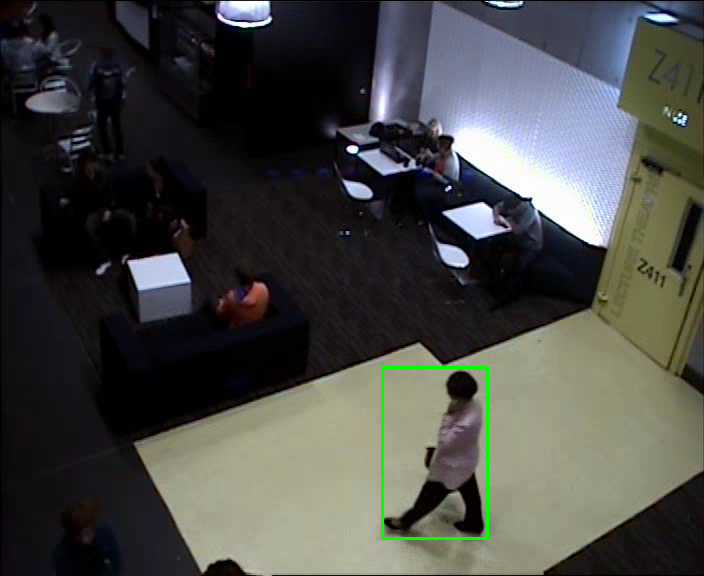

----------------Frame_no:- 51 ----------------
0 : color class1 =  Pink  color_class2 =  Purple
1 : color class1 =  Black  color_class2 =  Purple
2 : color class1 =  Purple  color_class2 =  Black
height pass: {'0': 1, '1': 1, '2': 0}
color pass: {'0': 1, '1': 0, '2': 0}
gender pass: {'0': 0, '1': 0, '2': 1}
{'0': 1.75, '1': 0.75, '2': 0.5}
success True
box (374.2635192871094, 360.4566650390625, 111.42682647705078, 181.466552734375)
box1 {'x1': 378, 'x2': 486, 'y1': 369, 'y2': 537}
box2 {'x1': 382, 'x2': 487, 'y1': 367, 'y2': 538}
0.9379932356257046


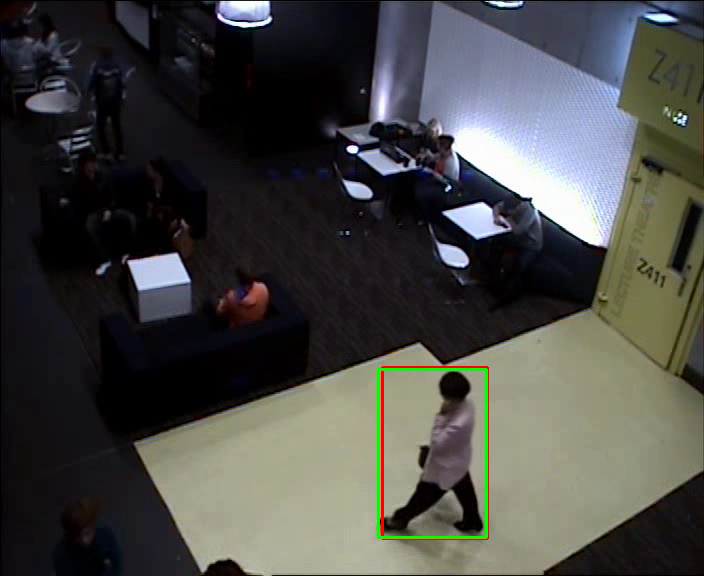

----------------Frame_no:- 52 ----------------
0 : color class1 =  Pink  color_class2 =  Red
1 : color class1 =  Black  color_class2 =  Purple
2 : color class1 =  Purple  color_class2 =  Black
height pass: {'0': 1, '1': 1, '2': 0}
color pass: {'0': 1, '1': 0, '2': 0}
gender pass: {'0': 0, '1': 0, '2': 1}
{'0': 1.75, '1': 0.75, '2': 0.5}
success True
box (373.72283935546875, 369.9974060058594, 105.88235473632812, 164.7058868408203)
box1 {'x1': 375, 'x2': 483, 'y1': 369, 'y2': 537}
box2 {'x1': 378, 'x2': 486, 'y1': 369, 'y2': 537}
0.9459459459459459


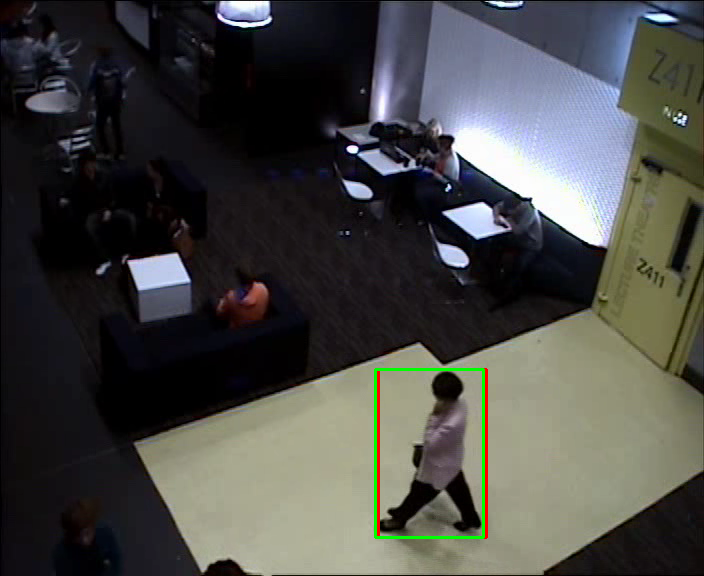

----------------Frame_no:- 53 ----------------
0 : color class1 =  Pink  color_class2 =  White
1 : color class1 =  Black  color_class2 =  Purple
2 : color class1 =  Purple  color_class2 =  Black
height pass: {'0': 1, '1': 1, '2': 0}
color pass: {'0': 1, '1': 0, '2': 0}
gender pass: {'0': 0, '1': 1, '2': 1}
{'0': 1.75, '1': 1.25, '2': 0.5}
success True
box (375.6435852050781, 369.1227722167969, 108.0, 168.0)
box1 {'x1': 375, 'x2': 483, 'y1': 369, 'y2': 536}
box2 {'x1': 375, 'x2': 483, 'y1': 369, 'y2': 537}
0.9940476190476191


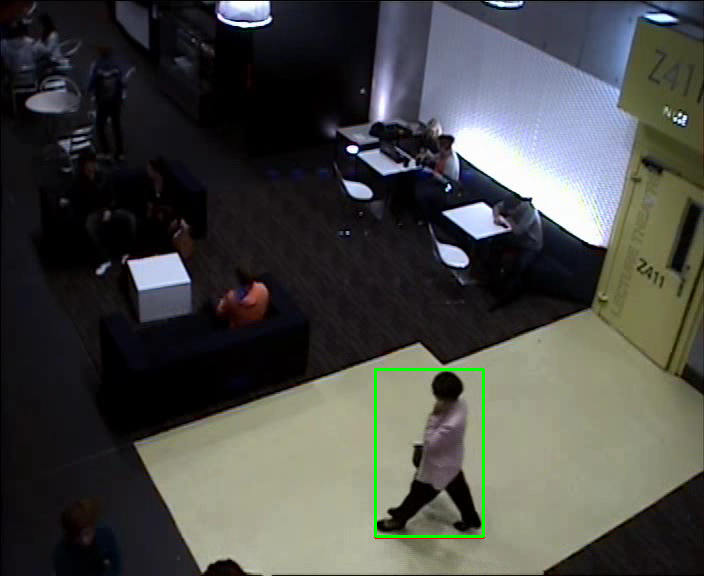

In [ ]:
attributes = {}
attributes['torso_color'] = 'Pink'          # ['Black','Blue','Brown','Green','Grey','Orange','Pink',
                                            # 'Purple','Red','White','Yellow','Skin']
attributes['torso_type'] = 'Long Sleeve'   # ['Long Sleeve','Short Sleeve','No Sleeve']
attributes['camera_calibration'] = "1"      # [0 = Camera calibration NOT available, 1 = Camera calibration available]
attributes['gender_type'] = "Female"        # ['Male','Female']
attributes['min_height'] = 150              # [130 - 160, 150 - 170, 160 - 180, 170 - 190, 180 - 210]
attributes['max_height'] = 170
attributes['camera_no'] = 1

initBB, initBB_prev, previous_frame = None, None, None
tracker = cv2.TrackerCSRT_create()

for i in range(50, 59):
  #print(i)
  if i < 10:
    path = '/content/gdrive/My Drive/PeR-ViS/DATASET/Testing/testing_subject_003/testing_subject_003_im_000' + str(i) + '.png'
  else:
    path = '/content/gdrive/My Drive/PeR-ViS/DATASET/Testing/testing_subject_003/testing_subject_003_im_00' + str(i) + '.png'
  #torso_color, height_range, camera_calibaration_available, camera_no, gender_type, torso_type
  current_frame = cv2.imread(path)

  #try:
  ret = test.filter(frame = current_frame, frame_no = i, prev_BB = initBB_prev, prev_frame = previous_frame, attributes = attributes)
  initBB = ret[0]
  #except:
  #  print("FAIL")
  """try:
    ret = test.filter(frame = current_frame, frame_no = i, prev_BB = initBB_prev,
                      prev_frame = previous_frame, attributes = attributes)
    ##print('------ ',ret[0],' ------')
    initBB = ret[0]
  except:
    print('2nd TRY IN Except')
    if initBB_prev != None and initBB == None:
      initBB = tracking(initBB_prev, previous_frame, current_frame, tracker)
      if initBB != None:
        (x1, y1, w, h) = [int(v) for v in box]
        y2 = y1 + h + 20
        x2 = x1 + w + 20
        x1 -= 10
        y1 -= 10
        detect_person(current_frame[x1:x2, y1:y2])
        cv2.rectangle(current_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imwrite('Final_OUTPUT.png', current_frame)
        cv2_imshow(current_frame)"""

  if initBB_prev != None and initBB == None:
    initBB = tracking(initBB_prev, previous_frame, current_frame, tracker)
    if initBB != None:
      (x1, y1, w, h) = [int(v) for v in box]
      y2 = y1 + h + 20
      x2 = x1 + w + 20
      x1 -= 10
      y1 -= 10
      detect_person(current_frame[x1:x2, y1:y2])
      cv2.rectangle(current_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.imwrite('Final_OUTPUT.png', current_frame)
      cv2_imshow(current_frame)



  initBB_prev = initBB
  previous_frame = current_frame
  #cv2_imshow(initBB)